# Notebook for analysing pipeline results

Importing libraries:

In [1]:
import os
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import nistats
import scipy
import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.input_data import NiftiMapsMasker, NiftiMasker, NiftiLabelsMasker, MultiNiftiMasker
from nilearn.regions import RegionExtractor
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm

/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
from logger import Logger
from utils import read_yaml, check_folder, fetch_masker, possible_subjects_id, get_subject_name

Some useful functions:

In [4]:
def fetch_map(path, distribution_name):
    path = os.path.join(path, '*' + distribution_name+'.nii.gz')
    files = sorted(glob.glob(path))
    return files

In [5]:
def load_atlas(name='cort-prob-2mm'):
    atlas = datasets.fetch_atlas_harvard_oxford(name)
    labels = atlas['labels']
    maps = nilearn.image.load_img(atlas['maps'])
    return maps, labels

In [6]:
def batchify(x, y, size=10):
    if len(x) != len(y):
        raise ValueError('vector length mismatch')
    m = len(x)
    x_batch = []
    y_batch = []
    last = 0
    for i in range(m//size):
        x_batch.append(x[last:last+size])
        y_batch.append(y[last:last+size])
        last = last+size
    x_batch.append(x[last:])
    y_batch.append(y[last:])
    return zip(x_batch, y_batch)

Defining variables:

In [7]:
language = 'english'

In [8]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_{language}"
SMOOTHED_MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/smoothed_global_masker_{language}"

Defining objects:

In [9]:
logger = Logger(os.path.join(PROJECT_PATH, 'logs.txt'))

In [10]:
masker = fetch_masker(MASKER_PATH, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
#smoothed_masker = fetch_masker(SMOOTHED_MASKER_PATH, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)

### Determination of the hrf for the following analysis

In [54]:
hrf_list = [
    'spm', # hrf model used in SPM
    'spm + derivative', # SPM model plus its time derivative (2 regressors)
    'spm + derivative + dispersion', # idem, plus dispersion derivative (3 regressors)
    'glover', # this one corresponds to the Glover hrf
    'glover + derivative', # the Glover hrf + time derivative (2 regressors)
    'glover + derivative + dispersion' # idem + dispersion derivative
]
subject_list = [57, 63, 67, 77] # identified correct subjects
model_name = 'bert-base-cased'
hidden_layer_list = [[1], [6], [8], [9], [10], [12]]
attention_layer_head_list = [[7, 6], [4, 10], [8, 1], [8,2], [6,7], [8, 10], [8, 11], [9, 6]]

In [28]:
reg_model_names = ['attention-layer-{}_head-{}'.format(layer, head) for hrf in hrf_list for subject in subject_list for (layer, head) in attention_layer_head_list ]
reg_model_names += ['hidden-layer-{}'.format(hidden_layers[0]) for hrf in hrf_list for subject in subject_list for hidden_layers in hidden_layer_list]


#### R2

In [29]:
distribution_name = 'R2'


    ##############################################################################
    ###################         HRF spm        ###################
    max: 0.2599216293039259
    75%: 0.008868061679319427
    median: 0.0004870379290168993
    mean: 0.008245440711537674
    25%: -0.0009432293895007395
    min: -8.608776142681336
    
    Data > 0.2: 0.006301956894614841
    Data > 0.15: 0.11418871894916238
    Data > 0.1: 0.7835661404075996
    Data > 0.05: 4.487952302406252
    
    ##############################################################################
    


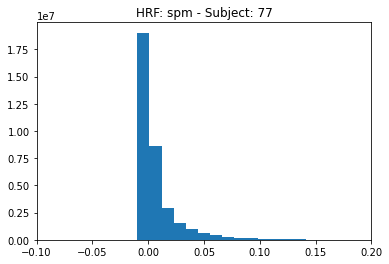


    ##############################################################################
    ###################         HRF spm + derivative        ###################
    max: 0.2806225481374186
    75%: 0.009290241862852456
    median: 0.000952237169993554
    mean: 0.008792892282731892
    25%: -0.0008220860145219203
    min: -3.0963193662103223
    
    Data > 0.2: 0.00815144424412137
    Data > 0.15: 0.12425815007425349
    Data > 0.1: 0.8514491760876356
    Data > 0.05: 4.914087887638849
    
    ##############################################################################
    


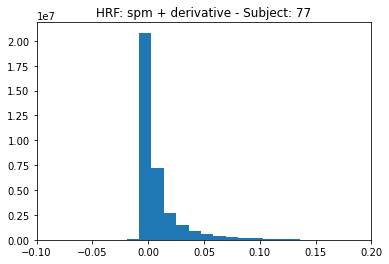


    ##############################################################################
    ###################         HRF spm + derivative + dispersion        ###################
    max: 0.2779681180954616
    75%: 0.009011966102095778
    median: 0.0009273725447779516
    mean: 0.00855674033185519
    25%: -0.0008598987594254185
    min: -6.305062982731245
    
    Data > 0.2: 0.008219943775584574
    Data > 0.15: 0.12186066647304132
    Data > 0.1: 0.8737800233446403
    Data > 0.05: 4.750579506036178
    
    ##############################################################################
    


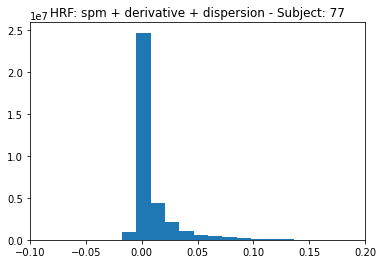

In [49]:
for hrf in hrf_list:
    imgs = []
    for subject in subject_list:
        paths = [os.path.join(OUTPUT_PATH, f"sub-0{subject}/{hrf.replace(' ', '')}_{subject}_{model_name}_{name}") for name in reg_model_names]
        imgs += [fetch_map(path, distribution_name)[0] for path in paths]
    data = np.hstack([masker.transform(img).reshape(-1) for img in imgs])
    print(f"""
    ##############################################################################
    ###################         HRF {hrf}        ###################
    max: {np.max(data)}
    75%: {np.percentile(data, 75)}
    median: {np.percentile(data, 50)}
    mean: {np.mean(data)}
    25%: {np.percentile(data, 25)}
    min: {np.min(data)}
    
    Data > 0.2: {100*np.sum(data>0.2)/len(data)}
    Data > 0.15: {100*np.sum(data>0.15)/len(data)}
    Data > 0.1: {100*np.sum(data>0.1)/len(data)}
    Data > 0.05: {100*np.sum(data>0.05)/len(data)}
    
    ##############################################################################
    """)
    data[data>1] = np.nan
    data[data<-0.4] = np.nan
    plt.hist(data[~np.isnan(data)], bins=50)
    plt.xlim((-0.1, 0.2))
    plt.title(f"HRF: {hrf}")
    plt.show()


##############################################################################
###################         HRF spm + derivative        ###################
max: 8.608776142681336
75%: 0.001549230584507042
median: 0.00010417790217025972
mean: 0.0005474515711942177
25%: -0.0009882186138779367
min: -3.1076800765959245

Data > 0.2: 0.001301491097800891
Data > 0.15: 0.001301491097800891
Data > 0.1: 0.0017124882865801197
Data > 0.05: 0.037469243710373024

##############################################################################



/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


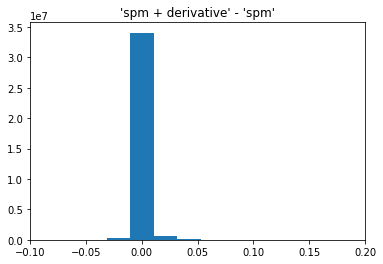

In [51]:
data= []
for hrf in ['spm', 'spm + derivative']: # 2 best identified hrf
    imgs = []
    for subject in subject_list:
        paths = [os.path.join(OUTPUT_PATH, f"sub-0{subject}/{hrf.replace(' ', '')}_{subject}_{model_name}_{name}") for name in reg_model_names]
        imgs += [fetch_map(path, distribution_name)[0] for path in paths]
    data.append(np.hstack([masker.transform(img).reshape(-1) for img in imgs]))
data = data[1] - data[0]
print(f"""
##############################################################################
###################         HRF {hrf}        ###################
max: {np.max(data)}
75%: {np.percentile(data, 75)}
median: {np.percentile(data, 50)}
mean: {np.mean(data)}
25%: {np.percentile(data, 25)}
min: {np.min(data)}

Data > 0.2: {100*np.sum(data>0.2)/len(data)}
Data > 0.15: {100*np.sum(data>0.15)/len(data)}
Data > 0.1: {100*np.sum(data>0.1)/len(data)}
Data > 0.05: {100*np.sum(data>0.05)/len(data)}

##############################################################################
""")
data[data>1] = np.nan
data[data<-0.4] = np.nan
plt.hist(data[~np.isnan(data)], bins=50)
plt.xlim((-0.1, 0.2))
plt.title("'spm + derivative' - 'spm'")
plt.show()

#### Pearson Coefficient 

In [55]:
distribution_name = 'Pearson_coeff'


    ##############################################################################
    ###################         HRF spm        ###################
    max: 0.5177206425608482
    75%: 0.10935408937988064
    median: 0.05272860980007671
    mean: 0.06821765055714024
    25%: 0.013264488465320832
    min: -0.19634181924787023
    
    Data > 0.2: 7.216083141991309
    Data > 0.15: 14.719727317065152
    Data > 0.1: 28.101590285122448
    Data > 0.05: 51.625425382090384
    
    ##############################################################################
    


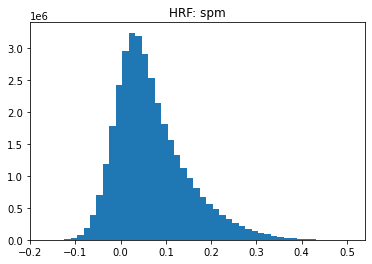


    ##############################################################################
    ###################         HRF spm + derivative        ###################
    max: 0.5339845743135865
    75%: 0.11068743671282957
    median: 0.05375653291149071
    mean: 0.0705422545486214
    25%: 0.015024430965312634
    min: -0.1615176317993926
    
    Data > 0.2: 7.596529539737948
    Data > 0.15: 15.230939320375048
    Data > 0.1: 28.50107955261586
    Data > 0.05: 52.25253859263603
    
    ##############################################################################
    


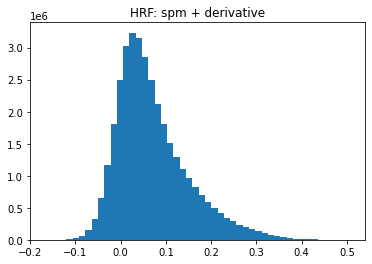


    ##############################################################################
    ###################         HRF spm + derivative + dispersion        ###################
    max: 0.530222279351241
    75%: 0.10970542017042477
    median: 0.052965020720797173
    mean: 0.07012533678257556
    25%: 0.014849196666799763
    min: -0.16155285805527209
    
    Data > 0.2: 7.471380895754673
    Data > 0.15: 15.004548368889157
    Data > 0.1: 28.189817681647057
    Data > 0.05: 51.785919784308675
    
    ##############################################################################
    


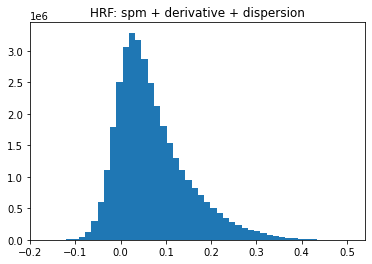


    ##############################################################################
    ###################         HRF glover        ###################
    max: 0.48897802426744175
    75%: 0.10117462198532827
    median: 0.04866590456718021
    mean: 0.0629889273437017
    25%: 0.011608101872994794
    min: -0.17624214333164767
    
    Data > 0.2: 5.8254741537567885
    Data > 0.15: 12.610284245655759
    Data > 0.1: 25.40161275296877
    Data > 0.05: 49.17101867023229
    
    ##############################################################################
    


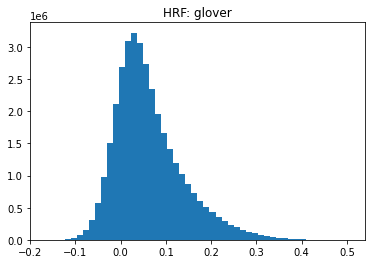


    ##############################################################################
    ###################         HRF glover + derivative        ###################
    max: 0.5115232108275165
    75%: 0.1026669654879825
    median: 0.04980188440204516
    mean: 0.0654211571212044
    25%: 0.013512289317017461
    min: -0.16210154497573864
    
    Data > 0.2: 6.246951770849887
    Data > 0.15: 13.207189162826126
    Data > 0.1: 25.883506956812415
    Data > 0.05: 49.87813933352696
    
    ##############################################################################
    


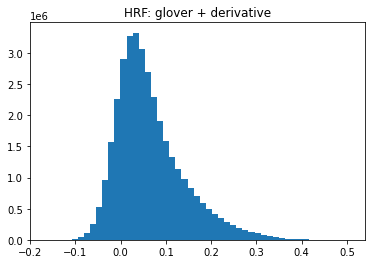


    ##############################################################################
    ###################         HRF glover + derivative + dispersion        ###################
    max: 0.5057571782285276
    75%: 0.10345571793622718
    median: 0.049496402220751606
    mean: 0.06492790853887725
    25%: 0.011924324305782682
    min: -0.16299576333185423
    
    Data > 0.2: 6.2807220398612476
    Data > 0.15: 13.259180307206698
    Data > 0.1: 26.175862957097372
    Data > 0.05: 49.69449208967411
    
    ##############################################################################
    


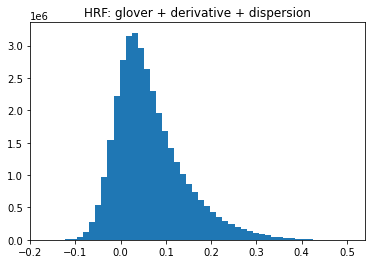

In [57]:
for hrf in hrf_list:
    imgs = []
    for subject in subject_list:
        paths = [os.path.join(OUTPUT_PATH, f"sub-0{subject}/{hrf.replace(' ', '')}_{subject}_{model_name}_{name}") for name in reg_model_names]
        imgs += [fetch_map(path, distribution_name)[0] for path in paths]
    data = np.hstack([masker.transform(img).reshape(-1) for img in imgs])
    print(f"""
    ##############################################################################
    ###################         HRF {hrf}        ###################
    max: {np.max(data)}
    75%: {np.percentile(data, 75)}
    median: {np.percentile(data, 50)}
    mean: {np.mean(data)}
    25%: {np.percentile(data, 25)}
    min: {np.min(data)}
    
    Data > 0.2: {100*np.sum(data>0.2)/len(data)}
    Data > 0.15: {100*np.sum(data>0.15)/len(data)}
    Data > 0.1: {100*np.sum(data>0.1)/len(data)}
    Data > 0.05: {100*np.sum(data>0.05)/len(data)}
    
    ##############################################################################
    """)
    data[data>1] = np.nan
    data[data<-0.4] = np.nan
    plt.hist(data[~np.isnan(data)], bins=50)
    plt.xlim((-0.2, 0.54))
    plt.title(f"HRF: {hrf}")
    plt.show()


##############################################################################
###################         HRF spm + derivative        ###################
max: 0.1638431133910795
75%: 0.012727405923583054
median: 0.0002137281977143829
mean: 0.0023246039914808082
25%: -0.010369441791048536
min: -0.09171806801510506

Data > 0.2: 0.0
Data > 0.15: 0.00034249765731602397
Data > 0.1: 0.07843196352536949
Data > 0.05: 2.0460810048059273

##############################################################################



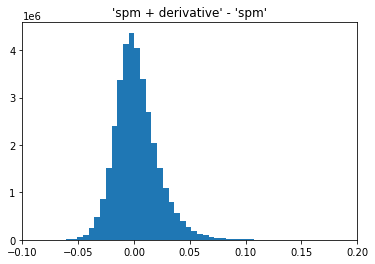

In [59]:
data= []
for hrf in ['spm', 'spm + derivative']: # 2 best identified hrf
    imgs = []
    for subject in subject_list:
        paths = [os.path.join(OUTPUT_PATH, f"sub-0{subject}/{hrf.replace(' ', '')}_{subject}_{model_name}_{name}") for name in reg_model_names]
        imgs += [fetch_map(path, distribution_name)[0] for path in paths]
    data.append(np.hstack([masker.transform(img).reshape(-1) for img in imgs]))
data = data[1] - data[0]
print(f"""
##############################################################################
###################         HRF {hrf}        ###################
max: {np.max(data)}
75%: {np.percentile(data, 75)}
median: {np.percentile(data, 50)}
mean: {np.mean(data)}
25%: {np.percentile(data, 25)}
min: {np.min(data)}

Data > 0.2: {100*np.sum(data>0.2)/len(data)}
Data > 0.15: {100*np.sum(data>0.15)/len(data)}
Data > 0.1: {100*np.sum(data>0.1)/len(data)}
Data > 0.05: {100*np.sum(data>0.05)/len(data)}

##############################################################################
""")
data[data>1] = np.nan
data[data<-0.4] = np.nan
plt.hist(data[~np.isnan(data)], bins=50)
plt.xlim((-0.1, 0.2))
plt.title("'spm + derivative' - 'spm'")
plt.show()

### Bert with sentence-level predictions VS Bert with sequential prediction

In [11]:
data = {}
model_names = ['bert-base-cased', 'bert-base-cased_sequential', 'roberta-base', 'gpt2']
analysis = {
    'Hidden-layers': 'hidden-layer-*',
    'Attention-layers': 'attention_layer-*',
    'Specific-attention-heads': 'attention-layer-*_head-*'
}

In [12]:
for model_name in model_names:
    data[model_name] = {}
    for analysis_of_interest in analysis.keys():
        R2_maps = {}
        Pearson_coeff_maps = {}
        data[model_name][analysis_of_interest] = {}
        for subject_id in tqdm(possible_subjects_id(language)):
            subject = get_subject_name(subject_id)
            path_to_map = os.path.join(OUTPUT_PATH, subject, '_'.join([model_name, str(subject_id), analysis[analysis_of_interest]]))
            R2_maps[subject] = fetch_map(path_to_map, 'R2')
            Pearson_coeff_maps[subject] = fetch_map(path_to_map, 'Pearson_coeff')
            print(subject, '-', len(R2_maps[subject]), '-', len(Pearson_coeff_maps[subject]))
        if analysis_of_interest == 'Hidden-layers':
            data[model_name][analysis_of_interest]['models'] = [os.path.dirname(name).split('_')[-1] for name in list(Pearson_coeff_maps.values())[-1]]
        else:
            data[model_name][analysis_of_interest]['models'] = ['-'.join(os.path.dirname(name).split('_')[-2:]) for name in list(Pearson_coeff_maps.values())[-1]]
        R2_lists = list(zip(*R2_maps.values()))
        Pearson_coeff_lists = list(zip(*Pearson_coeff_maps.values()))
        for index, model in enumerate(data[model_name][analysis_of_interest]['models']):
            try:
                data[model_name][analysis_of_interest][model] = {'R2': list(R2_lists[index]),
                                                                 'Pearson_coeff': list(Pearson_coeff_lists[index])
                                                                }
            except:
                print(model_name)
                print(analysis_of_interest)
                print(model)
                print(index)
                print(data[model_name][analysis_of_interest]['models'])
                

  2%|▏         | 1/51 [00:00<00:49,  1.00it/s]

sub-057 - 13 - 13


  4%|▍         | 2/51 [00:01<00:42,  1.15it/s]

sub-058 - 13 - 13


  6%|▌         | 3/51 [00:02<00:39,  1.21it/s]

sub-059 - 13 - 13


  8%|▊         | 4/51 [00:02<00:36,  1.29it/s]

sub-061 - 13 - 13


 10%|▉         | 5/51 [00:03<00:36,  1.25it/s]

sub-062 - 13 - 13


 12%|█▏        | 6/51 [00:04<00:35,  1.26it/s]

sub-063 - 13 - 13


 14%|█▎        | 7/51 [00:05<00:31,  1.41it/s]

sub-064 - 13 - 13


 16%|█▌        | 8/51 [00:05<00:31,  1.35it/s]

sub-065 - 13 - 13


 18%|█▊        | 9/51 [00:06<00:31,  1.34it/s]

sub-066 - 13 - 13


 20%|█▉        | 10/51 [00:07<00:25,  1.59it/s]

sub-067 - 13 - 13


 22%|██▏       | 11/51 [00:07<00:23,  1.72it/s]

sub-068 - 13 - 13


 24%|██▎       | 12/51 [00:08<00:21,  1.78it/s]

sub-069 - 13 - 13


 25%|██▌       | 13/51 [00:08<00:22,  1.68it/s]

sub-070 - 13 - 13


 27%|██▋       | 14/51 [00:09<00:24,  1.50it/s]

sub-072 - 13 - 13


 29%|██▉       | 15/51 [00:10<00:24,  1.45it/s]

sub-073 - 13 - 13


 31%|███▏      | 16/51 [00:11<00:24,  1.40it/s]

sub-074 - 13 - 13


 33%|███▎      | 17/51 [00:11<00:21,  1.59it/s]

sub-075 - 13 - 13


 35%|███▌      | 18/51 [00:12<00:20,  1.63it/s]

sub-076 - 13 - 13


 37%|███▋      | 19/51 [00:12<00:17,  1.83it/s]

sub-077 - 13 - 13


 39%|███▉      | 20/51 [00:13<00:18,  1.65it/s]

sub-078 - 13 - 13


 41%|████      | 21/51 [00:13<00:17,  1.69it/s]

sub-079 - 13 - 13


 43%|████▎     | 22/51 [00:14<00:18,  1.59it/s]

sub-080 - 13 - 13


 45%|████▌     | 23/51 [00:15<00:18,  1.52it/s]

sub-081 - 13 - 13


 47%|████▋     | 24/51 [00:15<00:16,  1.62it/s]

sub-082 - 13 - 13


 49%|████▉     | 25/51 [00:16<00:14,  1.83it/s]

sub-083 - 13 - 13


 51%|█████     | 26/51 [00:16<00:12,  2.02it/s]

sub-084 - 13 - 13


 53%|█████▎    | 27/51 [00:16<00:10,  2.22it/s]

sub-086 - 13 - 13


 55%|█████▍    | 28/51 [00:17<00:12,  1.87it/s]

sub-087 - 13 - 13


 57%|█████▋    | 29/51 [00:17<00:10,  2.01it/s]

sub-088 - 13 - 13


 59%|█████▉    | 30/51 [00:18<00:09,  2.15it/s]

sub-089 - 13 - 13


 63%|██████▎   | 32/51 [00:19<00:07,  2.60it/s]

sub-091 - 13 - 13
sub-092 - 13 - 13


 65%|██████▍   | 33/51 [00:19<00:06,  2.57it/s]

sub-093 - 13 - 13


 67%|██████▋   | 34/51 [00:19<00:06,  2.75it/s]

sub-094 - 13 - 13


 69%|██████▊   | 35/51 [00:19<00:05,  3.11it/s]

sub-095 - 13 - 13


 71%|███████   | 36/51 [00:20<00:05,  2.96it/s]

sub-096 - 13 - 13


 73%|███████▎  | 37/51 [00:20<00:04,  3.31it/s]

sub-097 - 13 - 13
sub-098 - 13 - 

 75%|███████▍  | 38/51 [00:20<00:03,  3.68it/s]

13


 78%|███████▊  | 40/51 [00:21<00:02,  3.90it/s]

sub-099 - 13 - 13
sub-100 - 13 - 13


 80%|████████  | 41/51 [00:21<00:02,  4.00it/s]

sub-101 - 13 - 13


 82%|████████▏ | 42/51 [00:21<00:02,  4.14it/s]

sub-103 - 13 - 13


 84%|████████▍ | 43/51 [00:22<00:02,  3.54it/s]

sub-104 - 13 - 13


 86%|████████▋ | 44/51 [00:22<00:02,  3.41it/s]

sub-105 - 13 - 13


 88%|████████▊ | 45/51 [00:22<00:01,  3.52it/s]

sub-106 - 13 - 13


 90%|█████████ | 46/51 [00:23<00:01,  3.16it/s]

sub-108 - 13 - 13


 92%|█████████▏| 47/51 [00:23<00:01,  2.84it/s]

sub-109 - 13 - 13


 94%|█████████▍| 48/51 [00:23<00:01,  2.61it/s]

sub-110 - 13 - 13


 98%|█████████▊| 50/51 [00:24<00:00,  2.99it/s]

sub-113 - 13 - 13
sub-114 - 13 - 13


 10%|▉         | 5/51 [00:00<00:01, 42.78it/s]

sub-115 - 13 - 13
sub-057 - 12 - 12
sub-058 - 12 - 12
sub-059 - 12 - 12
sub-061 - 12 - 12
sub-062 - 12 - 12
sub-063 - 12 - 12
sub-064 - 12 - 12
sub-065 - 12 - 12


 29%|██▉       | 15/51 [00:00<00:00, 43.73it/s]

sub-066 - 12 - 12
sub-067 - 12 - 12
sub-068 - 12 - 12
sub-069 - 12 - 12
sub-070 - 12 - 12
sub-072 - 12 - 12
sub-073 - 12 - 12
sub-074 - 12 - 12
sub-075 - 12 - 12
sub-076 - 12 - 12


 49%|████▉     | 25/51 [00:00<00:00, 44.61it/s]

sub-077 - 12 - 12
sub-078 - 12 - 12
sub-079 - 12 - 12
sub-080 - 12 - 12
sub-081 - 12 - 12
sub-082 - 12 - 12
sub-083 - 12 - 12
sub-084 - 12 - 12
sub-086 - 12 - 12
sub-087 - 12 - 12


 59%|█████▉    | 30/51 [00:00<00:00, 44.42it/s]

sub-088 - 12 - 12
sub-089 - 12 - 12
sub-091 - 12 - 12
sub-092 - 12 - 12


 67%|██████▋   | 34/51 [00:01<00:01, 11.78it/s]

sub-093 - 12 - 12
sub-094 - 12 - 12
sub-095 - 12 - 12


 73%|███████▎  | 37/51 [00:02<00:01,  7.27it/s]

sub-096 - 12 - 12
sub-097 - 12 - 12
sub-098 - 12 - 12
sub-099 - 12 - 12


 78%|███████▊  | 40/51 [00:03<00:01,  6.01it/s]

sub-100 - 12 - 12
sub-101 - 12 - 12


 82%|████████▏ | 42/51 [00:03<00:01,  5.47it/s]

sub-103 - 12 - 12
sub-104 - 12 - 12


 86%|████████▋ | 44/51 [00:03<00:01,  5.24it/s]

sub-105 - 12 - 12
sub-106 - 12 - 12


 90%|█████████ | 46/51 [00:04<00:01,  4.31it/s]

sub-108 - 12 - 12


 92%|█████████▏| 47/51 [00:04<00:01,  3.82it/s]

sub-109 - 12 - 12


 96%|█████████▌| 49/51 [00:05<00:00,  3.90it/s]

sub-110 - 12 - 12
sub-113 - 12 - 12


 98%|█████████▊| 50/51 [00:05<00:00,  3.59it/s]

sub-114 - 12 - 12
sub-115 - 12 - 

 10%|▉         | 5/51 [00:00<00:00, 49.28it/s]

12
sub-057 - 8 - 8
sub-058 - 8 - 8
sub-059 - 8 - 8
sub-061 - 8 - 8
sub-062 - 8 - 8
sub-063 - 8 - 8
sub-064 - 8 - 8
sub-065 - 8 - 8
sub-066 - 8 - 8


 31%|███▏      | 16/51 [00:00<00:00, 50.31it/s]

sub-067 - 8 - 8
sub-068 - 8 - 8
sub-069 - 8 - 8
sub-070 - 8 - 8
sub-072 - 8 - 8
sub-073 - 8 - 8
sub-074 - 8 - 8
sub-075 - 8 - 8
sub-076 - 8 - 8
sub-077 - 8 - 8
sub-078 - 8 - 8


 53%|█████▎    | 27/51 [00:00<00:00, 49.90it/s]

sub-079 - 8 - 8
sub-080 - 8 - 8
sub-081 - 8 - 8
sub-082 - 8 - 8
sub-083 - 8 - 8
sub-084 - 8 - 8
sub-086 - 8 - 8
sub-087 - 8 - 8
sub-088 - 8 - 8
sub-089 - 8 - 8
sub-091 - 8 - 8


 63%|██████▎   | 32/51 [00:01<00:00, 21.24it/s]

sub-092 - 8 - 8
sub-093 - 8 - 8
sub-094 - 8 - 8
sub-095 - 8 - 8


 71%|███████   | 36/51 [00:01<00:01, 13.49it/s]

sub-096 - 8 - 8
sub-097 - 8 - 8


 76%|███████▋  | 39/51 [00:02<00:01,  9.49it/s]

sub-098 - 8 - 8
sub-099 - 8 - 8


 80%|████████  | 41/51 [00:02<00:01,  7.70it/s]

sub-100 - 8 - 8
sub-101 - 8 - 8
sub-103 - 8 - 8


 84%|████████▍ | 43/51 [00:02<00:01,  7.33it/s]

sub-104 - 8 - 8
sub-105 - 8 - 8


 90%|█████████ | 46/51 [00:03<00:00,  6.07it/s]

sub-106 - 8 - 8
sub-108 - 8 - 8


 94%|█████████▍| 48/51 [00:03<00:00,  6.82it/s]

sub-109 - 8 - 8
sub-110 - 8 - 8


 96%|█████████▌| 49/51 [00:03<00:00,  6.47it/s]

sub-113 - 8 - 8
sub-114 - 8 - 8


  8%|▊         | 4/51 [00:00<00:01, 39.81it/s]

sub-115 - 8 - 8
sub-057 - 13 - 13
sub-058 - 13 - 13
sub-059 - 13 - 13
sub-061 - 13 - 13
sub-062 - 13 - 13
sub-063 - 13 - 13
sub-064 - 13 - 13
sub-065 - 13 - 13


 27%|██▋       | 14/51 [00:00<00:00, 41.74it/s]

sub-066 - 13 - 13
sub-067 - 13 - 13
sub-068 - 13 - 13
sub-069 - 13 - 13
sub-070 - 13 - 13
sub-072 - 13 - 13
sub-073 - 13 - 13
sub-074 - 13 - 13
sub-075 - 13 - 13


 47%|████▋     | 24/51 [00:00<00:00, 44.05it/s]

sub-076 - 13 - 13
sub-077 - 13 - 13
sub-078 - 13 - 13
sub-079 - 13 - 13
sub-080 - 13 - 13
sub-081 - 13 - 13
sub-082 - 13 - 13
sub-083 - 13 - 13
sub-084 - 13 - 13
sub-086 - 13 - 13


 57%|█████▋    | 29/51 [00:00<00:00, 44.30it/s]

sub-087 - 13 - 13
sub-088 - 13 - 13
sub-089 - 13 - 13
sub-091 - 13 - 13


 65%|██████▍   | 33/51 [00:01<00:01, 17.46it/s]

sub-092 - 13 - 13
sub-093 - 13 - 13
sub-094 - 13 - 13
sub-095 - 13 - 13


 71%|███████   | 36/51 [00:02<00:01,  8.30it/s]

sub-096 - 13 - 13
sub-097 - 13 - 13
sub-098 - 13 - 13


 76%|███████▋  | 39/51 [00:03<00:02,  5.22it/s]

sub-099 - 13 - 13
sub-100 - 13 - 13


 80%|████████  | 41/51 [00:03<00:02,  4.76it/s]

sub-101 - 13 - 13
sub-103 - 13 - 13


 84%|████████▍ | 43/51 [00:04<00:01,  4.61it/s]

sub-104 - 13 - 13


 88%|████████▊ | 45/51 [00:04<00:01,  4.22it/s]

sub-105 - 13 - 13
sub-106 - 13 - 13


 92%|█████████▏| 47/51 [00:04<00:00,  4.92it/s]

sub-108 - 13 - 13
sub-109 - 13 - 13


 96%|█████████▌| 49/51 [00:05<00:00,  5.13it/s]

sub-110 - 13 - 13
sub-113 - 13 - 13


 98%|█████████▊| 50/51 [00:05<00:00,  4.67it/s]

sub-114 - 13 - 13
sub-115 - 13 - 13


 10%|▉         | 5/51 [00:00<00:01, 43.70it/s]

sub-057 - 12 - 12
sub-058 - 12 - 12
sub-059 - 12 - 12
sub-061 - 12 - 12
sub-062 - 12 - 12
sub-063 - 12 - 12
sub-064 - 12 - 12
sub-065 - 12 - 12


 29%|██▉       | 15/51 [00:00<00:00, 42.69it/s]

sub-066 - 12 - 12
sub-067 - 12 - 12
sub-068 - 12 - 12
sub-069 - 12 - 12
sub-070 - 12 - 12
sub-072 - 12 - 12
sub-073 - 12 - 12
sub-074 - 12 - 12
sub-075 - 12 - 12


 49%|████▉     | 25/51 [00:00<00:00, 44.84it/s]

sub-076 - 12 - 12
sub-077 - 12 - 12
sub-078 - 12 - 12
sub-079 - 12 - 12
sub-080 - 12 - 12
sub-081 - 12 - 12
sub-082 - 12 - 12
sub-083 - 12 - 12
sub-084 - 12 - 12
sub-086 - 12 - 12


 59%|█████▉    | 30/51 [00:00<00:00, 44.20it/s]

sub-087 - 12 - 12
sub-088 - 12 - 12
sub-089 - 12 - 12
sub-091 - 12 - 12
sub-092 - 12 - 12
sub-093 - 12 - 12


 67%|██████▋   | 34/51 [00:01<00:01, 13.14it/s]

sub-094 - 12 - 12
sub-095 - 12 - 12
sub-096 - 12 - 12


 73%|███████▎  | 37/51 [00:02<00:01,  9.43it/s]

sub-097 - 12 - 12
sub-098 - 12 - 12


 78%|███████▊  | 40/51 [00:02<00:01,  7.18it/s]

sub-099 - 12 - 12
sub-100 - 12 - 12
sub-101 - 12 - 12


 82%|████████▏ | 42/51 [00:03<00:01,  5.61it/s]

sub-103 - 12 - 12
sub-104 - 12 - 12


 86%|████████▋ | 44/51 [00:03<00:01,  5.30it/s]

sub-105 - 12 - 12
sub-106 - 12 - 12


 92%|█████████▏| 47/51 [00:04<00:00,  6.44it/s]

sub-108 - 12 - 12
sub-109 - 12 - 12


 94%|█████████▍| 48/51 [00:04<00:00,  5.98it/s]

sub-110 - 12 - 12


 96%|█████████▌| 49/51 [00:04<00:00,  4.77it/s]

sub-113 - 12 - 12


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 12 - 12
sub-115 - 12 - 12
sub-057 - 8 - 8
sub-058 - 8 - 8


 25%|██▌       | 13/51 [00:00<00:00, 60.43it/s]

sub-059 - 8 - 8
sub-061 - 8 - 8
sub-062 - 8 - 8
sub-063 - 8 - 8
sub-064 - 8 - 8
sub-065 - 8 - 8
sub-066 - 8 - 8
sub-067 - 8 - 8
sub-068 - 8 - 8
sub-069 - 8 - 8
sub-070 - 8 - 8
sub-072 - 8 - 8
sub-073 - 8 - 8


 53%|█████▎    | 27/51 [00:00<00:00, 62.25it/s]

sub-074 - 8 - 8
sub-075 - 8 - 8
sub-076 - 8 - 8
sub-077 - 8 - 8
sub-078 - 8 - 8
sub-079 - 8 - 8
sub-080 - 8 - 8
sub-081 - 8 - 8
sub-082 - 8 - 8
sub-083 - 8 - 8
sub-084 - 8 - 8
sub-086 - 8 - 8
sub-087 - 8 - 8
sub-088 - 8 - 8
sub-089 - 8 - 8
sub-091 - 8 - 8


 63%|██████▎   | 32/51 [00:00<00:00, 34.13it/s]

sub-092 - 8 - 8
sub-093 - 8 - 8
sub-094 - 8 - 8
sub-095 - 8 - 8


 71%|███████   | 36/51 [00:01<00:00, 16.59it/s]

sub-096 - 8 - 8
sub-097 - 8 - 8
sub-098 - 8 - 8


 76%|███████▋  | 39/51 [00:01<00:01,  9.92it/s]

sub-099 - 8 - 8
sub-100 - 8 - 8


 82%|████████▏ | 42/51 [00:02<00:01,  8.57it/s]

sub-101 - 8 - 8
sub-103 - 8 - 8


 86%|████████▋ | 44/51 [00:02<00:00,  8.82it/s]

sub-104 - 8 - 8
sub-105 - 8 - 8
sub-106 - 8 - 8


 94%|█████████▍| 48/51 [00:02<00:00, 10.58it/s]

sub-108 - 8 - 8
sub-109 - 8 - 8
sub-110 - 8 - 8


 98%|█████████▊| 50/51 [00:03<00:00,  9.94it/s]

sub-113 - 8 - 8
sub-114 - 8 - 8


  8%|▊         | 4/51 [00:00<00:01, 37.86it/s]

sub-115 - 8 - 8
sub-057 - 13 - 13
sub-058 - 13 - 13
sub-059 - 13 - 13
sub-061 - 13 - 13
sub-062 - 13 - 13
sub-063 - 13 - 13
sub-064 - 13 - 13


 25%|██▌       | 13/51 [00:00<00:00, 39.20it/s]

sub-065 - 13 - 13
sub-066 - 13 - 13
sub-067 - 13 - 13
sub-068 - 13 - 13
sub-069 - 13 - 13
sub-070 - 13 - 13
sub-072 - 13 - 13
sub-073 - 13 - 13
sub-074 - 13 - 13


 45%|████▌     | 23/51 [00:00<00:00, 40.16it/s]

sub-075 - 13 - 13
sub-076 - 13 - 13
sub-077 - 13 - 13
sub-078 - 13 - 13
sub-079 - 13 - 13
sub-080 - 13 - 13
sub-081 - 13 - 13
sub-082 - 13 - 13
sub-083 - 13 - 13


 53%|█████▎    | 27/51 [00:00<00:00, 39.60it/s]

sub-084 - 13 - 13
sub-086 - 13 - 13
sub-087 - 13 - 13
sub-088 - 13 - 13
sub-089 - 13 - 13


 61%|██████    | 31/51 [00:00<00:00, 26.38it/s]

sub-091 - 13 - 13
sub-092 - 13 - 13
sub-093 - 13 - 13


 67%|██████▋   | 34/51 [00:01<00:01, 10.59it/s]

sub-094 - 13 - 13
sub-095 - 13 - 13
sub-096 - 13 - 13


 73%|███████▎  | 37/51 [00:02<00:02,  6.29it/s]

sub-097 - 13 - 13
sub-098 - 13 - 13


 76%|███████▋  | 39/51 [00:03<00:02,  5.56it/s]

sub-099 - 13 - 13
sub-100 - 13 - 13


 80%|████████  | 41/51 [00:03<00:02,  4.99it/s]

sub-101 - 13 - 13


 84%|████████▍ | 43/51 [00:03<00:01,  5.04it/s]

sub-103 - 13 - 13
sub-104 - 13 - 13


 88%|████████▊ | 45/51 [00:04<00:00,  6.04it/s]

sub-105 - 13 - 13
sub-106 - 13 - 13


 90%|█████████ | 46/51 [00:04<00:01,  3.85it/s]

sub-108 - 13 - 13


 92%|█████████▏| 47/51 [00:05<00:01,  3.10it/s]

sub-109 - 13 - 13


 94%|█████████▍| 48/51 [00:05<00:00,  3.22it/s]

sub-110 - 13 - 13


 98%|█████████▊| 50/51 [00:05<00:00,  3.79it/s]

sub-113 - 13 - 13
sub-114 - 13 - 13


 10%|▉         | 5/51 [00:00<00:01, 45.47it/s]

sub-115 - 13 - 13
sub-057 - 12 - 12
sub-058 - 12 - 12
sub-059 - 12 - 12
sub-061 - 12 - 12
sub-062 - 12 - 12
sub-063 - 12 - 12
sub-064 - 12 - 12
sub-065 - 12 - 12


 29%|██▉       | 15/51 [00:00<00:00, 44.50it/s]

sub-066 - 12 - 12
sub-067 - 12 - 12
sub-068 - 12 - 12
sub-069 - 12 - 12
sub-070 - 12 - 12
sub-072 - 12 - 12
sub-073 - 12 - 12
sub-074 - 12 - 12
sub-075 - 12 - 12


 49%|████▉     | 25/51 [00:00<00:00, 43.61it/s]

sub-076 - 12 - 12
sub-077 - 12 - 12
sub-078 - 12 - 12
sub-079 - 12 - 12
sub-080 - 12 - 12
sub-081 - 12 - 12
sub-082 - 12 - 12
sub-083 - 12 - 12
sub-084 - 12 - 12


 59%|█████▉    | 30/51 [00:00<00:00, 43.64it/s]

sub-086 - 12 - 12
sub-087 - 12 - 12
sub-088 - 12 - 12
sub-089 - 12 - 12
sub-091 - 12 - 12
sub-092 - 12 - 12
sub-093 - 12 - 12


 67%|██████▋   | 34/51 [00:01<00:01, 10.24it/s]

sub-094 - 12 - 12
sub-095 - 12 - 12
sub-096 - 12 - 12


 73%|███████▎  | 37/51 [00:02<00:01,  8.35it/s]

sub-097 - 12 - 12
sub-098 - 12 - 12


 78%|███████▊  | 40/51 [00:02<00:01,  6.80it/s]

sub-099 - 12 - 12
sub-100 - 12 - 12


 82%|████████▏ | 42/51 [00:03<00:01,  6.63it/s]

sub-101 - 12 - 12
sub-103 - 12 - 12


 86%|████████▋ | 44/51 [00:03<00:01,  5.98it/s]

sub-104 - 12 - 12
sub-105 - 12 - 12
sub-106 - 12 - 12


 90%|█████████ | 46/51 [00:04<00:00,  5.10it/s]

sub-108 - 12 - 12


 92%|█████████▏| 47/51 [00:04<00:00,  4.35it/s]

sub-109 - 12 - 12


 96%|█████████▌| 49/51 [00:04<00:00,  5.20it/s]

sub-110 - 12 - 12
sub-113 - 12 - 12


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 12 - 12
sub-115 - 12 - 12
sub-057 - 8 - 8


 27%|██▋       | 14/51 [00:00<00:00, 64.28it/s]

sub-058 - 8 - 8
sub-059 - 8 - 8
sub-061 - 8 - 8
sub-062 - 8 - 8
sub-063 - 8 - 8
sub-064 - 8 - 8
sub-065 - 8 - 8
sub-066 - 8 - 8
sub-067 - 8 - 8
sub-068 - 8 - 8
sub-069 - 8 - 8
sub-070 - 8 - 8
sub-072 - 8 - 8
sub-073 - 8 - 8


 55%|█████▍    | 28/51 [00:00<00:00, 62.76it/s]

sub-074 - 8 - 8
sub-075 - 8 - 8
sub-076 - 8 - 8
sub-077 - 8 - 8
sub-078 - 8 - 8
sub-079 - 8 - 8
sub-080 - 8 - 8
sub-081 - 8 - 8
sub-082 - 8 - 8
sub-083 - 8 - 8
sub-084 - 8 - 8
sub-086 - 8 - 8
sub-087 - 8 - 8
sub-088 - 8 - 8
sub-089 - 8 - 8
sub-091 - 8 - 8
sub-092 - 8 - 8


 65%|██████▍   | 33/51 [00:00<00:00, 24.76it/s]

sub-093 - 8 - 8
sub-094 - 8 - 8
sub-095 - 8 - 8


 73%|███████▎  | 37/51 [00:01<00:01, 13.58it/s]

sub-096 - 8 - 8
sub-097 - 8 - 8
sub-098 - 8 - 8


 78%|███████▊  | 40/51 [00:01<00:00, 12.61it/s]

sub-099 - 8 - 8
sub-100 - 8 - 8
sub-101 - 8 - 8


 84%|████████▍ | 43/51 [00:02<00:00, 11.56it/s]

sub-103 - 8 - 8
sub-104 - 8 - 8


 88%|████████▊ | 45/51 [00:02<00:00,  9.79it/s]

sub-105 - 8 - 8
sub-106 - 8 - 8
sub-108 - 8 - 8


 96%|█████████▌| 49/51 [00:02<00:00,  8.65it/s]

sub-109 - 8 - 8
sub-110 - 8 - 8
sub-113 - 8 - 8


100%|██████████| 51/51 [00:03<00:00, 16.48it/s]

sub-114 - 8 - 8
sub-115 - 8 - 8


In [21]:
print(data['bert-base-cased']['Specific-attention-heads'].keys()) #'Attention-layers', 'Specific-attention-heads']
print(data['bert-base-cased']['Specific-attention-heads']['models']) #'Attention-layers', 'Specific-attention-heads']

dict_keys(['models', 'attention-layer-4-head-10', 'attention-layer-6-head-7', 'attention-layer-7-head-6', 'attention-layer-8-head-1', 'attention-layer-8-head-10', 'attention-layer-8-head-11', 'attention-layer-8-head-2', 'attention-layer-9-head-6'])
['attention-layer-4-head-10', 'attention-layer-6-head-7', 'attention-layer-7-head-6', 'attention-layer-8-head-1', 'attention-layer-8-head-10', 'attention-layer-8-head-11', 'attention-layer-8-head-2', 'attention-layer-9-head-6']


In [14]:
def create_one_sample_t_test(name, maps, output_dir, smoothing_fwhm=None, vmax=None, design_matrix=None):
    """ Do a one sample t-test over the maps.
    """
    print('##### ', name, ' #####')

    model = SecondLevelModel(smoothing_fwhm=smoothing_fwhm, n_jobs=-1)
    design_matrix = design_matrix if (design_matrix is not None) else pd.DataFrame([1] * len(maps),
                                                             columns=['intercept'])
    model = model.fit(maps,
                      design_matrix=design_matrix)
    z_map = model.compute_contrast(output_type='z_score')
    nib.save(z_map, os.path.join(output_dir, "{}_group_zmap.nii.gz".format(name)))

    p_val = 0.001
    z_th = norm.isf(p_val)  # 3.09
    display = plotting.plot_glass_brain(
        z_map,
        threshold=z_th,
        colorbar=True,
        plot_abs=False,
        display_mode='lzry',
        title=name + ' z values (P<.001 unc.)',
        vmax=10)
    display.savefig(os.path.join(output_dir, "{}_group_zmap".format(name)))

    # apply fdr to zmap
    thresholded_zmap, th = map_threshold(stat_img=z_map,
                                         alpha=0.01,
                                         height_control='fdr',
                                         cluster_threshold=0)
    nib.save(thresholded_zmap, os.path.join(output_dir, "{}_group_fdr_zmap.nii.gz".format(name)))

    display = plotting.plot_glass_brain(
        thresholded_zmap,
        #threshold=np.max([th, z_th]),
        threshold=th,
        colorbar=True,
        plot_abs=False,
        display_mode='lzry',
        title=name + ' z values (Pfdr<.01: Z >{}'.format(np.round(th,2)),
        vmax=10)
    display.savefig(os.path.join(output_dir, "{}_fdr_group_zmap".format(name)))

    # effect size-map
    eff_map = model.compute_contrast(output_type='effect_size')
    nib.save(eff_map, os.path.join(output_dir, "{}_group_effect.nii.gz".format(name)))

    display = plotting.plot_glass_brain(
        smooth_img(eff_map, fwhm=6),
        colorbar=True,
        plot_abs=False,
        display_mode='lzry',
        title=None, vmax=vmax)
    display.savefig(os.path.join(output_dir, "{}_group_effect".format(name)))

    #thr = thresholded_zmap.get_data()
    thr = np.abs(z_map.get_data())
    eff = eff_map.get_data()
    thr_eff = eff * (thr > 3.09)
    eff_thr_map = new_img_like(eff_map, thr_eff)
    nib.save(eff_thr_map, os.path.join(output_dir, "{}_group_fdr_effect.nii.gz".format(name)))

    display = plotting.plot_glass_brain(
        smooth_img(eff_thr_map, fwhm=6),
        colorbar=True,
        plot_abs=False,
        display_mode='lzry',
        title=None,
        vmax=vmax)
    display.savefig(os.path.join(output_dir, "{}_group_fdr_effect".format(name)))
    plt.close('all')


In [15]:
#smoothing_fwhm = None # 5.0
#for model_name in ['bert-base-cased']:
#    for analysis_of_interest in ['Specific-attention-heads']:
#        for key in tqdm(data[model_name][analysis_of_interest].keys()):
#            if key != 'models':
#                # R2
#                imgs = data[model_name][analysis_of_interest][key]['R2']
#                name = '_'.join([model_name, key])
#                output_dir = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
#                check_folder(output_dir)
#                create_one_sample_t_test(name + '_R2', imgs, output_dir, smoothing_fwhm=smoothing_fwhm, vmax=None)
#                # Pearson coefficient
#                imgs = data[model_name][analysis_of_interest][key]['Pearson_coeff']
#                create_one_sample_t_test(name + '_Pearson_coeff', imgs, output_dir, smoothing_fwhm=smoothing_fwhm, vmax=None)
#                plt.close('all')

  0%|          | 0/9 [00:00<?, ?it/s]

#####  bert-base-cased_attention-layer-4-head-10_R2  #####
#####  bert-base-cased_attention-layer-4-head-10_Pearson_coeff  #####


 22%|██▏       | 2/9 [00:27<01:37, 13.94s/it]

#####  bert-base-cased_attention-layer-6-head-7_R2  #####
#####  bert-base-cased_attention-layer-6-head-7_Pearson_coeff  #####


 33%|███▎      | 3/9 [00:57<01:52, 18.74s/it]

#####  bert-base-cased_attention-layer-7-head-6_R2  #####
#####  bert-base-cased_attention-layer-7-head-6_Pearson_coeff  #####


 44%|████▍     | 4/9 [01:26<01:49, 21.84s/it]

#####  bert-base-cased_attention-layer-8-head-1_R2  #####
#####  bert-base-cased_attention-layer-8-head-1_Pearson_coeff  #####


 56%|█████▌    | 5/9 [01:58<01:39, 24.86s/it]

#####  bert-base-cased_attention-layer-8-head-10_R2  #####
#####  bert-base-cased_attention-layer-8-head-10_Pearson_coeff  #####


 67%|██████▋   | 6/9 [02:29<01:19, 26.50s/it]

#####  bert-base-cased_attention-layer-8-head-11_R2  #####
#####  bert-base-cased_attention-layer-8-head-11_Pearson_coeff  #####


 78%|███████▊  | 7/9 [02:58<00:54, 27.42s/it]

#####  bert-base-cased_attention-layer-8-head-2_R2  #####
#####  bert-base-cased_attention-layer-8-head-2_Pearson_coeff  #####


 89%|████████▉ | 8/9 [03:27<00:27, 27.86s/it]

#####  bert-base-cased_attention-layer-9-head-6_R2  #####
#####  bert-base-cased_attention-layer-9-head-6_Pearson_coeff  #####


100%|██████████| 9/9 [03:56<00:00, 26.24s/it]


In [84]:
smoothing_fwhm = None # 5.0
for model_name in model_names:
    for analysis_of_interest in analysis.keys():
        for key in tqdm(data[model_name][analysis_of_interest].keys()):
            if key != 'models':
                # R2
                imgs = data[model_name][analysis_of_interest][key]['R2']
                name = '_'.join([model_name, key])
                output_dir = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
                check_folder(output_dir)
                create_one_sample_t_test(name + '_R2', imgs, output_dir, smoothing_fwhm=smoothing_fwhm, vmax=None)
                # Pearson coefficient
                imgs = data[model_name][analysis_of_interest][key]['Pearson_coeff']
                create_one_sample_t_test(name + '_Pearson_coeff', imgs, output_dir, smoothing_fwhm=smoothing_fwhm, vmax=None)
                plt.close('all')

  0%|          | 0/14 [00:00<?, ?it/s]

#####  bert-base-cased_hidden-layer-0_R2  #####
#####  bert-base-cased_hidden-layer-0_Pearson_coeff  #####


 14%|█▍        | 2/14 [00:35<03:31, 17.60s/it]

#####  bert-base-cased_hidden-layer-1_R2  #####
#####  bert-base-cased_hidden-layer-1_Pearson_coeff  #####


 21%|██▏       | 3/14 [01:46<06:11, 33.77s/it]

#####  bert-base-cased_hidden-layer-10_R2  #####
#####  bert-base-cased_hidden-layer-10_Pearson_coeff  #####


 29%|██▊       | 4/14 [03:17<08:30, 51.00s/it]

#####  bert-base-cased_hidden-layer-11_R2  #####
#####  bert-base-cased_hidden-layer-11_Pearson_coeff  #####


 36%|███▌      | 5/14 [05:35<11:31, 76.84s/it]

#####  bert-base-cased_hidden-layer-12_R2  #####
#####  bert-base-cased_hidden-layer-12_Pearson_coeff  #####


 43%|████▎     | 6/14 [08:09<13:20, 100.07s/it]

#####  bert-base-cased_hidden-layer-2_R2  #####
#####  bert-base-cased_hidden-layer-2_Pearson_coeff  #####


 50%|█████     | 7/14 [11:32<15:17, 131.14s/it]

#####  bert-base-cased_hidden-layer-3_R2  #####
#####  bert-base-cased_hidden-layer-3_Pearson_coeff  #####


 57%|█████▋    | 8/14 [15:18<15:57, 159.53s/it]

#####  bert-base-cased_hidden-layer-4_R2  #####
#####  bert-base-cased_hidden-layer-4_Pearson_coeff  #####


 64%|██████▍   | 9/14 [19:27<15:31, 186.37s/it]

#####  bert-base-cased_hidden-layer-5_R2  #####
#####  bert-base-cased_hidden-layer-5_Pearson_coeff  #####


 71%|███████▏  | 10/14 [24:23<14:36, 219.10s/it]

#####  bert-base-cased_hidden-layer-6_R2  #####
#####  bert-base-cased_hidden-layer-6_Pearson_coeff  #####


 79%|███████▊  | 11/14 [29:43<12:28, 249.41s/it]

#####  bert-base-cased_hidden-layer-7_R2  #####
#####  bert-base-cased_hidden-layer-7_Pearson_coeff  #####


 86%|████████▌ | 12/14 [35:38<09:22, 281.29s/it]

#####  bert-base-cased_hidden-layer-8_R2  #####
#####  bert-base-cased_hidden-layer-8_Pearson_coeff  #####


 93%|█████████▎| 13/14 [42:07<05:13, 313.39s/it]

#####  bert-base-cased_hidden-layer-9_R2  #####
#####  bert-base-cased_hidden-layer-9_Pearson_coeff  #####


  0%|          | 0/13 [00:00<?, ?it/s]

#####  bert-base-cased_attention-layer-1_R2  #####
#####  bert-base-cased_attention-layer-1_Pearson_coeff  #####


 15%|█▌        | 2/13 [07:17<40:05, 218.67s/it]

#####  bert-base-cased_attention-layer-10_R2  #####
#####  bert-base-cased_attention-layer-10_Pearson_coeff  #####


 23%|██▎       | 3/13 [14:51<48:14, 289.41s/it]

#####  bert-base-cased_attention-layer-11_R2  #####
#####  bert-base-cased_attention-layer-11_Pearson_coeff  #####


 31%|███       | 4/13 [22:58<52:18, 348.68s/it]

#####  bert-base-cased_attention-layer-12_R2  #####
#####  bert-base-cased_attention-layer-12_Pearson_coeff  #####


 38%|███▊      | 5/13 [31:17<52:30, 393.80s/it]

#####  bert-base-cased_attention-layer-2_R2  #####
#####  bert-base-cased_attention-layer-2_Pearson_coeff  #####


 38%|███▊      | 5/13 [37:04<59:18, 444.85s/it]


KeyboardInterrupt: 

Group analysis of the difference between the models:

La prochaine fois, faire la différence entre les images et passer un intercept de 1 (voir ancien script)

In [15]:
smoothing_fwhm = None # 5.0

In [303]:
for analysis_of_interest in analysis.keys():
    for key in tqdm(data['bert-base-cased'][analysis_of_interest].keys()):
        if key != 'models':
            # R2
            print('Retrieving data...')
            imgs_bert = data['bert-base-cased'][analysis_of_interest][key]['R2']
            imgs_bert_seq = data['bert-base-cased_sequential'][analysis_of_interest][key]['R2']
            imgs_roberta = data['roberta-base'][analysis_of_interest][key]['R2']
            imgs_gpt2 = data['gpt2'][analysis_of_interest][key]['R2']
            
            imgs_bert_vs_bert_seq = []
            imgs_roberta_vs_bert = []
            imgs_bert_vs_gpt2 = []
            imgs_bert_seq_vs_gpt2 = []
            for img_bert, img_bert_seq, img_roberta, img_gpt2 in zip(imgs_bert, imgs_bert_seq, imgs_roberta, imgs_gpt2):
                i1 = nib.load(img_bert)
                i2 = nib.load(img_bert_seq)
                i3 = nib.load(img_roberta)
                i4 = nib.load(img_gpt2)
                imgs_bert_vs_bert_seq.append(new_img_like(i1, i1.get_data() - i2.get_data()))
                imgs_roberta_vs_bert.append(new_img_like(i3, i3.get_data() - i1.get_data()))
                imgs_bert_vs_gpt2.append(new_img_like(i1, i1.get_data() - i4.get_data()))
                imgs_bert_seq_vs_gpt2.append(new_img_like(i2, i2.get_data() - i4.get_data()))
                
            name_1 = '_'.join(['Bert-VS-Bert_sequential', key])
            name_2 = '_'.join(['RoBerta-VS-Bert', key])
            name_3 = '_'.join(['Bert-VS-GPT2', key])
            name_4 = '_'.join(['Bert_sequential-VS-GTP2', key])
            output_dir_1 = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name_1))
            output_dir_2 = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name_2))
            output_dir_3 = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name_3))
            output_dir_4 = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name_4))
            check_folder(output_dir_1)
            check_folder(output_dir_2)
            check_folder(output_dir_3)
            check_folder(output_dir_4)
            print('One sample t-test...')
            create_one_sample_t_test(name_1 + '_R2', imgs_bert_vs_bert_seq, output_dir_1, smoothing_fwhm=smoothing_fwhm, vmax=None)
            create_one_sample_t_test(name_2 + '_R2', imgs_roberta_vs_bert, output_dir_2, smoothing_fwhm=smoothing_fwhm, vmax=None)
            create_one_sample_t_test(name_3 + '_R2', imgs_bert_vs_gpt2, output_dir_3, smoothing_fwhm=smoothing_fwhm, vmax=None)
            create_one_sample_t_test(name_4 + '_R2', imgs_bert_seq_vs_gpt2, output_dir_4, smoothing_fwhm=smoothing_fwhm, vmax=None)
            # Pearson Coefficient
            print('Retrieving data...')
            imgs_bert = data['bert-base-cased'][analysis_of_interest][key]['Pearson_coeff']
            imgs_bert_seq = data['bert-base-cased_sequential'][analysis_of_interest][key]['Pearson_coeff']
            imgs_roberta = data['roberta-base'][analysis_of_interest][key]['Pearson_coeff']
            imgs_gpt2 = data['gpt2'][analysis_of_interest][key]['Pearson_coeff']
            
            imgs_bert_vs_bert_seq = []
            imgs_bert_vs_roberta = []
            imgs_bert_vs_gpt2 = []
            imgs_bert_seq_vs_gpt2 = []
            for img_bert, img_bert_seq, img_roberta, img_gpt2 in zip(imgs_bert, imgs_bert_seq, imgs_roberta, imgs_gpt2):
                i1 = nib.load(img_bert)
                i2 = nib.load(img_bert_seq)
                i3 = nib.load(img_roberta)
                i4 = nib.load(img_gpt2)
                imgs_bert_vs_bert_seq.append(new_img_like(i1, i1.get_data() - i2.get_data()))
                imgs_bert_vs_roberta.append(new_img_like(i3, i3.get_data() - i1.get_data()))
                imgs_bert_vs_gpt2.append(new_img_like(i1, i1.get_data() - i4.get_data()))
                imgs_bert_seq_vs_gpt2.append(new_img_like(i2, i2.get_data() - i4.get_data()))
            create_one_sample_t_test(name_1 + '_Pearson_coeff', imgs_bert_vs_bert_seq, output_dir_1, smoothing_fwhm=smoothing_fwhm, vmax=None)
            create_one_sample_t_test(name_2 + '_Pearson_coeff', imgs_bert_vs_roberta, output_dir_2, smoothing_fwhm=smoothing_fwhm, vmax=None)
            create_one_sample_t_test(name_3 + '_Pearson_coeff', imgs_bert_vs_gpt2, output_dir_3, smoothing_fwhm=smoothing_fwhm, vmax=None)
            create_one_sample_t_test(name_4 + '_Pearson_coeff', imgs_bert_seq_vs_gpt2, output_dir_4, smoothing_fwhm=smoothing_fwhm, vmax=None)
            

  0%|          | 0/14 [00:00<?, ?it/s]

Retrieving data...
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/sub-057/bert-base-cased_57_hidden-layer-0/sub-057_bert-base-cased_57_hidden-layer-0_R2.nii.gz /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/sub-057/bert-base-cased_sequential_57_hidden-layer-0/sub-057_bert-base-cased_sequential_57_hidden-layer-0_R2.nii.gz /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/sub-057/roberta-base_57_hidden-layer-0/sub-057_roberta-base_57_hidden-layer-0_R2.nii.gz

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/sub-058/bert-base-cased_58_hidden-layer-0/sub-058_bert-base-cased_58_hidden-layer-0_R2.nii.gz /neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/sub-058/bert-base-cased_sequential_58_hidden-layer-0/sub-058_bert-ba

  7%|▋         | 1/14 [00:31<06:52, 31.75s/it]


KeyboardInterrupt: Interrupted by user

In [ ]:
#imgs = []
#for img1, img2 in zip(files1, files2):
#    i1 = nibabel.load(img1)
#    i2 = nibabel.load(img2)
#    imgs.append(new_img_like(i1, i1.get_data() - i2.get_data()))
#
#
#vmax= None
#create_one_sample_t_test(name, imgs, output_dir, smoothing_fwhm=5.0, vmax=vmax)


### Attention heads analysis

In [22]:
surnames = {'attention-layer-4-head-10': 'L4-H10', 
            'attention-layer-6-head-7': 'L6-H7', 
            'attention-layer-7-head-6': 'L7-H6', 
            'attention-layer-8-head-1': 'L8-H1', 
            'attention-layer-8-head-10': 'L8-H10', 
            'attention-layer-8-head-11': 'L8-H11', 
            'attention-layer-8-head-2': 'L8-H2', 
            'attention-layer-9-head-6': 'L9-H6',
            'attention-layer-1': 'A-L1', 
            'attention-layer-10': 'A-L10', 
            'attention-layer-11': 'A-L11', 
            'attention-layer-12': 'A-L12', 
            'attention-layer-2': 'A-L2', 
            'attention-layer-3': 'A-L3', 
            'attention-layer-4': 'A-L4', 
            'attention-layer-5': 'A-L5', 
            'attention-layer-6': 'A-L6', 
            'attention-layer-7': 'A-L7', 
            'attention-layer-8': 'A-L8', 
            'attention-layer-9': 'A-L9',
            'hidden-layer-1': 'H-L1', 
            'hidden-layer-10': 'H-L10',  
            'hidden-layer-11': 'H-L11',  
            'hidden-layer-0': 'H-L0', 
            'hidden-layer-12': 'H-L12',
            'hidden-layer-2': 'H-L2', 
            'hidden-layer-3': 'H-L3', 
            'hidden-layer-4': 'H-L4',
            'hidden-layer-5': 'H-L5',
            'hidden-layer-6': 'H-L6',
            'hidden-layer-7': 'H-L7',
            'hidden-layer-8': 'H-L8',
            'hidden-layer-9': 'H-L9',
            'word_position': 'Word-position',
                'wordrate': 'Wordrate',
                'log_frequency': 'Log-frequency',
                'function_words': 'Function-words',
               'content-words': 'Content-words',
                'wordrate_all_model': 'All-word-related-models',
                'topdown_model': 'Topdown-parser',
                'rms': 'RMS',
                'other_sentence_onset': 'Sentence-onset',
                'mfcc': 'MFCC',
                'gpt2_hidden-layer-9': 'GPT2-H-L9',
                'gpt2_hidden-layer-8': 'GPT2-H-L8',
                'gpt2_hidden-layer-7': 'GPT2-H-L7',
                'gpt2_hidden-layer-6': 'GPT2-H-L6',
                'gpt2_hidden-layer-5': 'GPT2-H-L5',
                'gpt2_hidden-layer-4': 'GPT2-H-L4',
                'gpt2_hidden-layer-3': 'GPT2-H-L3',
                'gpt2_hidden-layer-2': 'GPT2-H-L2',
                'gpt2_hidden-layer-12': 'GPT2-H-L12',
                'gpt2_hidden-layer-11': 'GPT2-H-L11',
                'gpt2_hidden-layer-10': 'GPT2-H-L10',
                'gpt2_hidden-layer-1': 'GPT2-H-L1',
                'gpt2_embeddings': 'GPT2-L0',
                'gpt2_all-hidden-layers': 'GPT2-all-hidden',
                'bottomup_model': 'Bottomup-parser',
                'bert_bucket_median_all-layers': 'BERT-median-all',
                'bert_bucket_layer-9': 'BERT-L9',
                'bert_bucket_layer-8': 'BERT-L8',
                'bert_bucket_layer-7': 'BERT-L7',
                'bert_bucket_layer-6': 'BERT-L6',
                'bert_bucket_layer-5': 'BERT-L5',
                'bert_bucket_layer-4': 'BERT-L4',
                'bert_bucket_layer-3': 'BERT-L3',
                'bert_bucket_layer-2': 'BERT-L2',
                'bert_bucket_layer-12': 'BERT-L12',
                'bert_bucket_layer-11': 'BERT-L11',
                'bert_bucket_layer-10': 'BERT-L10',
                'bert_bucket_layer-1': 'BERT-L1',
                'bert_bucket_embeddings': 'BERT-L0',
                'bert_bucket_all-layers': 'BERT-all',
                'glove_embeddings': 'GloVe',
                'lstm_wikikristina_embedding-size_600_nhid_768_nlayers_1_dropout_02_hidden_first-layer': 'LSTM-E600-H768-#L1-all',
                'lstm_wikikristina_embedding-size_600_nhid_300_nlayers_1_dropout_02_hidden_first-layer': 'LSTM-E600-H300-#L1-all',
                'lstm_wikikristina_embedding-size_600_nhid_150_nlayers_2_dropout_02_hidden_all-layers': 'LSTM-E600-H150-#L2-all',
                'lstm_wikikristina_embedding-size_600_nhid_100_nlayers_3_dropout_02_hidden_all-layers': 'LSTM-E600-H100-#L3-all',
                'lstm_wikikristina_embedding-size_600_nhid_75_nlayers_4_dropout_02_hidden_all-layers': 'LSTM-E600-H75-#L4-all',
                'lstm_wikikristina_embedding-size_600_nhid_150_nlayers_2_dropout_02_hidden_first-layer': 'LSTM-E600-H150-#L2-L1',
                'lstm_wikikristina_embedding-size_600_nhid_150_nlayers_2_dropout_02_hidden_second-layer': 'LSTM-E600-H150-#L2-L2',
                'lstm_wikikristina_embedding-size_600_nhid_100_nlayers_3_dropout_02_hidden_first-layer': 'LSTM-E600-H100-#L3-L1',
                'lstm_wikikristina_embedding-size_600_nhid_100_nlayers_3_dropout_02_hidden_second-layer': 'LSTM-E600-H100-#L3-L2',
                'lstm_wikikristina_embedding-size_600_nhid_100_nlayers_3_dropout_02_hidden_third-layer': 'LSTM-E600-H100-#L3-L3',
                'lstm_wikikristina_embedding-size_600_nhid_75_nlayers_4_dropout_02_hidden_first-layer': 'LSTM-E600-H75-#L4-L1',
                'lstm_wikikristina_embedding-size_600_nhid_75_nlayers_4_dropout_02_hidden_second-layer': 'LSTM-E600-H75-#L4-L2',
                'lstm_wikikristina_embedding-size_600_nhid_75_nlayers_4_dropout_02_hidden_third-layer': 'LSTM-E600-H75-#L4-L3',
                'lstm_wikikristina_embedding-size_600_nhid_75_nlayers_4_dropout_02_hidden_fourth-layer': 'LSTM-E600-H75-#L4-L4',
                'lstm_wikikristina_embedding-size_600_nhid_768_nlayers_1_dropout_02_cell_first-layer': 'LSTM-E600-C768-#L1-all',
                'lstm_wikikristina_embedding-size_600_nhid_300_nlayers_1_dropout_02_cell_first-layer': 'LSTM-E600-C300-#L1-all',
                'lstm_wikikristina_embedding-size_600_nhid_150_nlayers_2_dropout_02_cell_all-layers': 'LSTM-E600-C150-#L2-all',
                'lstm_wikikristina_embedding-size_600_nhid_100_nlayers_3_dropout_02_cell_all-layers': 'LSTM-E600-C100-#L3-all',
                'lstm_wikikristina_embedding-size_600_nhid_75_nlayers_4_dropout_02_cell_all-layers': 'LSTM-E600-C75-#L4-all',
                'lstm_wikikristina_embedding-size_600_nhid_150_nlayers_2_dropout_02_cell_first-layer': 'LSTM-E600-C150-#L2-L1',
                'lstm_wikikristina_embedding-size_600_nhid_150_nlayers_2_dropout_02_cell_second-layer': 'LSTM-E600-C150-#L2-L2',
                'lstm_wikikristina_embedding-size_600_nhid_100_nlayers_3_dropout_02_cell_first-layer': 'LSTM-E600-C100-#L3-L1',
                'lstm_wikikristina_embedding-size_600_nhid_100_nlayers_3_dropout_02_cell_second-layer': 'LSTM-E600-C100-#L3-L2',
                'lstm_wikikristina_embedding-size_600_nhid_100_nlayers_3_dropout_02_cell_third-layer': 'LSTM-E600-C100-#L3-L3',
                'lstm_wikikristina_embedding-size_600_nhid_75_nlayers_4_dropout_02_cell_first-layer': 'LSTM-E600-C75-#L4-L1',
                'lstm_wikikristina_embedding-size_600_nhid_75_nlayers_4_dropout_02_cell_second-layer': 'LSTM-E600-C75-#L4-L2',
                'lstm_wikikristina_embedding-size_600_nhid_75_nlayers_4_dropout_02_cell_third-layer': 'LSTM-E600-C75-#L4-L3',
                'lstm_wikikristina_embedding-size_600_nhid_75_nlayers_4_dropout_02_cell_fourth-layer': 'LSTM-E600-C75-#L4-L4',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_cell_unit_775': 'LSTM-E650-H650-Cu775',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_cell_unit_775_987': 'LSTM-E650-H650-Cu775-987',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_cell_unit_987': 'LSTM-E650-H650-Cu987',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_forget_unit_775': 'LSTM-E650-H650-Fu775',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_forget_unit_987': 'LSTM-E650-H650-Fu775',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_hidden_short-range-units': 'LSTM-E650-H650-Short-Range',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_hidden_unit_1149': 'LSTM-E650-H650-Hu1149',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_input_unit_775': 'LSTM-E650-H650-Iu775',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_input_unit_987': 'LSTM-E650-H650-Iu987',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_forget_unit_775_987': 'LSTM-E650-H650-Fu775-987',
                'lstm_wikikristina_embedding-size_650_nhid_650_nlayers_2_dropout_02_hidden_unit_1282_1283': 'LSTM-E650-H650-Hu1282-1283',
                'bert_bucket_pca_300_all-layers': 'BERT-all-pca-300',
                'gpt2_pca_300_all-layers':'GPT2-all-pca-300',
                'maps_r2_':'R2', 
                'maps_pearson_corr':'Pearson',
                'maps_significant_pearson_corr_with_pvalues':'Significant-Pearson', 
                'maps_significant_r2_with_pvalues':'Significant-R2',
                'Background': 'Background', 
                'Frontal Pole': 'FP', 
                'Insular Cortex': 'InsC', 
                'Superior Frontal Gyrus': 'SFG', 
                'Middle Frontal Gyrus': 'MFG', 
                'Inferior Frontal Gyrus, pars triangularis': 'IFG, pars tr.', 
                'Inferior Frontal Gyrus, pars opercularis': 'IFG, pars op.', 
                'Precentral Gyrus': 'PrG', 
                'Temporal Pole': 'TP', 
                'Superior Temporal Gyrus, anterior division': 'STG-a', 
                'Superior Temporal Gyrus, posterior division': 'STG-p', 
                'Middle Temporal Gyrus, anterior division': 'MTG-a', 
                'Middle Temporal Gyrus, posterior division': 'MTG-p', 
                'Middle Temporal Gyrus, temporooccipital part': 'MTG-toc', 
                'Inferior Temporal Gyrus, anterior division': 'ITG-a', 
                'Inferior Temporal Gyrus, posterior division': 'ITG-p', 
                'Inferior Temporal Gyrus, temporooccipital part': 'ITG-toc', 
                'Postcentral Gyrus': 'PoG', 
                'Superior Parietal Lobule': 'SPL', 
                'Supramarginal Gyrus, anterior division': 'SmG-a', 
                'Supramarginal Gyrus, posterior division': 'SmG-p', 
                'Angular Gyrus': 'AnG', 
                'Lateral Occipital Cortex, superior division': 'LOC-s', 
                'Lateral Occipital Cortex, inferior division': 'LOC-i', 
                'Intracalcarine Cortex': 'IccC', 
                'Frontal Medial Cortex': 'FMC', 
                'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)': 'SMA', 
                'Subcallosal Cortex': 'SC', 
                'Paracingulate Gyrus': 'PCgG', 
                'Cingulate Gyrus, anterior division': 'CgG-a', 
                'Cingulate Gyrus, posterior division': 'CgG-p', 
                'Precuneous Cortex': 'PrCuG', 
                'Cuneal Cortex': 'CuC', 
                'Frontal Orbital Cortex': 'FoG', 
                'Parahippocampal Gyrus, anterior division': 'PHG-a', 
                'Parahippocampal Gyrus, posterior division': 'PHG-p', 
                'Lingual Gyrus': 'LgG', 
                'Temporal Fusiform Cortex, anterior division': 'TFuC-a', 
                'Temporal Fusiform Cortex, posterior division': 'TFuC-p', 
                'Temporal Occipital Fusiform Cortex': 'TocFucC', 
                'Occipital Fusiform Gyrus': 'OcFuC', 
                'Frontal Operculum Cortex': 'FOpC', 
                'Central Opercular Cortex': 'cOpC', 
                'Parietal Operculum Cortex': 'POpC', 
                'Planum Polare': 'PP', 
                "Heschl's Gyrus (includes H1 and H2)": 'HG', 
                'Planum Temporale': 'PT', 
                'Supracalcarine Cortex': 'SccC', 
                'Occipital Pole': 'OcP'}

In [23]:
limit_values = {'maps_r2_':0.07,
                'maps_pearson_corr':0.6,
                'maps_significant_pearson_corr_with_pvalues':0.4,
                'maps_significant_r2_with_pvalues':0.07}

syntactic_roi = ['Inferior Frontal Gyrus, pars triangularis',
                    'Inferior Frontal Gyrus, pars opercularis',
                    'Temporal Pole',
                    'Superior Temporal Gyrus, anterior division',
                    'Superior Temporal Gyrus, posterior division',
                    'Middle Temporal Gyrus, anterior division',
                    'Middle Temporal Gyrus, posterior division',
                    'Middle Temporal Gyrus, temporooccipital part',
                    'Angular Gyrus']

language_roi = ['Inferior Frontal Gyrus, pars triangularis',
                    'Inferior Frontal Gyrus, pars opercularis',
                    'Temporal Pole',
                    'Superior Temporal Gyrus, anterior division',
                    'Superior Temporal Gyrus, posterior division',
                    'Middle Temporal Gyrus, anterior division',
                    'Middle Temporal Gyrus, posterior division',
                    'Middle Temporal Gyrus, temporooccipital part',
                    'Angular Gyrus']

In [24]:
syntactic_roi += [surnames[item] for item in syntactic_roi]
language_roi += [surnames[item] for item in language_roi]

In [25]:
def vertical_plot(data, x_names, analysis_name, save_folder, object_of_interest, surnames, models, syntactic_roi, language_roi, figsize=(9,12), count=False, title=None, ylabel='Regions of interest (ROI)', xlabel='R2 value', model_name=''):
    """Plots models vertically.
    """
    #limit = (-0.01, 0.05) if object_of_interest=='R2' else None
    limit = None
    dash_inf = limit[0] if limit else 0
    x = x_names.copy()
    plt.figure(figsize=figsize) # (7.6,12)
    ax = plt.axes()
    order = np.argsort(np.mean(data, axis=1))
    data = data[order, :]
    x = [surnames[x[i]] for i in order]
    ax = plt.axes()
    # set possible colors
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1,data.shape[1] + 1)]
    for col in range(data.shape[1]):
        plt.plot(data[:,col], x, '.', alpha=0.7, markersize=9, color=colors[col])
    plt.title(title)
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    if count:
        plt.axvline(x=100, color='k', linestyle='-', alpha=0.2)
    for col in range(data.shape[1]):
        plt.hlines(x, dash_inf, data[:,col], linestyle="dashed", alpha=0.05)
    plt.xlim(limit)
    plt.minorticks_on()
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='x')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='x')
    plt.legend([surnames[model] for model in models], ncol=3, bbox_to_anchor=(0,0,1,1), fontsize=5)
    for index, label in enumerate(x):
        if label in language_roi:
            if label in syntactic_roi:
                ax.get_yticklabels()[index].set_bbox(dict(facecolor="green", alpha=0.4)) # set box around label
            #ax.axhspan(index-0.5, index+0.5, alpha=0.1, color='red') #set shade over the line of interest
    plt.tight_layout()
    check_folder(save_folder)
    plt.savefig(os.path.join(save_folder, '{model_name}-{analysis_name}.png'.format(model_name=model_name,
                                                                                    analysis_name=analysis_name)))
    #plt.show()
    plt.close('all')

In [26]:
atlas_maps, labels = load_atlas() # load harvard-oxford atlas named'cort-prob-2mm'

### R2

In [27]:
for model_name in model_names:
    for key in analysis:
        maps = []
        for model in data[model_name][key].keys():
            if model == 'models':
                models = data[model_name][key][model]
            else:
                name = '_'.join([model_name, model])
                path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
                name = 'R2_group_fdr_effect'
                maps.append(fetch_map(path, name)[0])
        plot_name = ["{} for {}".format(model_name, key)]
        x_labels = labels[1:]

        mean = np.zeros((len(labels)-1, len(models)))
        third_quartile = np.zeros((len(labels)-1, len(models)))
        # extract data
        print("\tLooping through labeled masks...")
        for index_mask in tqdm(range(len(labels)-1)):
            mask = math_img('img > 50', img=index_img(atlas_maps, index_mask))  
            masker = NiftiMasker(mask_img=mask, memory='nilearn_cache', verbose=0)
            masker.fit()

            for index_model, model in enumerate(models):
                array = masker.transform(maps[index_model])
                third_quartile[index_mask, index_model] = np.percentile(array, 75)
                mean[index_mask, index_model] = np.mean(array)
        print("\t\t-->Done")
        
        # Small reordering of models so that layers are in increasing order
        if key=='Hidden-layers':
            mean = np.hstack([mean[:, :2], mean[:,5:], mean[:,2:5]])
            third_quartile = np.hstack([third_quartile[:, :2], third_quartile[:,5:], third_quartile[:,2:5]])
            models = models[:2] + models[5:] + models[2:5]
        elif key=='Attention-layers':
            mean = np.hstack([mean[:, :1], mean[:,4:], mean[:,1:4]])
            third_quartile = np.hstack([third_quartile[:, :1], third_quartile[:,4:], third_quartile[:,1:4]])
            models = models[:1] + models[4:] + models[1:4]
        elif key=='Specific-attention-heads':
            mean = np.hstack([mean[:, :4], mean[:,6:7], mean[:,4:6], mean[:,7:]])
            third_quartile = np.hstack([third_quartile[:, :4], third_quartile[:,6:7], third_quartile[:,4:6], third_quartile[:,7:]])
            models = models[:4] + models[6:7] + models[4:6] + models[7:]

        print("\tPlotting...")
        vertical_plot(mean, x_labels, '{}-Mean_R2_per_ROI'.format(key), 
                        os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, key + '-Average')), 
                        'R2', surnames, models, syntactic_roi, language_roi, xlabel='Average R2 values', title='{}-{}'.format(model_name, key), model_name=model_name)
        vertical_plot(third_quartile, x_labels, '{}-R2_Third_quartile_per_ROI'.format(key), 
                        os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language,  key + '-3rd_Quartile')), 
                        'R2', surnames, models, syntactic_roi, language_roi, xlabel='Third Quartile R2 values', title='{}-{}'.format(model_name, key), model_name=model_name)
        print("\t\t-->Done")

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [01:12<00:00,  1.50s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:57<00:00,  1.20s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:39<00:00,  1.21it/s]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done


  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [01:04<00:00,  1.35s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:55<00:00,  1.16s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:39<00:00,  1.23it/s]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [01:00<00:00,  1.26s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:41<00:00,  1.15it/s]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done


In [28]:
for model_name in ['Bert-VS-Bert_sequential', 'RoBerta-VS-Bert', 'Bert-VS-GPT2', 'Bert_sequential-VS-GTP2']:
    for mod in ['bert-base-cased']:
        for key in analysis:
            maps = []
            for model in data[mod][key].keys():
                if model == 'models':
                    models = data[mod][key][model]
                else:
                    name = '_'.join([model_name, model])
                    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
                    name = 'R2_group_fdr_effect'
                    maps.append(fetch_map(path, name)[0])
            plot_name = ["{} for {}".format(model_name, key)]
            x_labels = labels[1:]

            mean = np.zeros((len(labels)-1, len(models)))
            third_quartile = np.zeros((len(labels)-1, len(models)))
            # extract data
            print("\tLooping through labeled masks...")
            for index_mask in tqdm(range(len(labels)-1)):
                mask = math_img('img > 50', img=index_img(atlas_maps, index_mask))  
                masker = NiftiMasker(mask_img=mask, memory='nilearn_cache', verbose=0)
                masker.fit()

                for index_model, model in enumerate(models):
                    array = masker.transform(maps[index_model])
                    third_quartile[index_mask, index_model] = np.percentile(array, 75)
                    mean[index_mask, index_model] = np.mean(array)
            print("\t\t-->Done")

            # Small reordering of models so that layers are in increasing order
            if key=='Hidden-layers':
                mean = np.hstack([mean[:, :2], mean[:,5:], mean[:,2:5]])
                third_quartile = np.hstack([third_quartile[:, :2], third_quartile[:,5:], third_quartile[:,2:5]])
                models = models[:2] + models[5:] + models[2:5]
            elif key=='Attention-layers':
                mean = np.hstack([mean[:, :1], mean[:,4:], mean[:,1:4]])
                third_quartile = np.hstack([third_quartile[:, :1], third_quartile[:,4:], third_quartile[:,1:4]])
                models = models[:1] + models[4:] + models[1:4]
            elif key=='Specific-attention-heads':
                mean = np.hstack([mean[:, :4], mean[:,6:7], mean[:,4:6], mean[:,7:]])
                third_quartile = np.hstack([third_quartile[:, :4], third_quartile[:,6:7], third_quartile[:,4:6], third_quartile[:,7:]])
                models = models[:4] + models[6:7] + models[4:6] + models[7:]

            print("\tPlotting...")
            vertical_plot(mean, x_labels, '{}-Mean_R2_per_ROI'.format(key), 
                            os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, key + '-Average')), 
                            'R2', surnames, models, syntactic_roi, language_roi, xlabel='Average R2 values', title='{}-{}'.format(model_name, key), model_name=model_name)
            vertical_plot(third_quartile, x_labels, '{}-R2_Third_quartile_per_ROI'.format(key), 
                            os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language,  key + '-3rd_Quartile')), 
                            'R2', surnames, models, syntactic_roi, language_roi, xlabel='Third Quartile R2 values', title='{}-{}'.format(model_name, key), model_name=model_name)
            print("\t\t-->Done")

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [01:01<00:00,  1.28s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:57<00:00,  1.20s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:42<00:00,  1.14it/s]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [01:05<00:00,  1.37s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:39<00:00,  1.22it/s]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done


### Pearson coefficient

In [29]:
for model_name in model_names:
    for key in analysis:
        maps = []
        for model in data[model_name][key].keys():
            if model == 'models':
                models = data[model_name][key][model]
            else:
                name = '_'.join([model_name, model])
                path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
                name = 'Pearson_coeff_group_fdr_effect'
                maps.append(fetch_map(path, name)[0])
        plot_name = ["{} for {}".format(model_name, key)]
        x_labels = labels[1:]

        mean = np.zeros((len(labels)-1, len(models)))
        third_quartile = np.zeros((len(labels)-1, len(models)))
        # extract data
        print("\tLooping through labeled masks...")
        for index_mask in tqdm(range(len(labels)-1)):
            mask = math_img('img > 50', img=index_img(atlas_maps, index_mask))  
            masker = NiftiMasker(mask_img=mask, memory='nilearn_cache', verbose=0)
            masker.fit()

            for index_model, model in enumerate(models):
                array = masker.transform(maps[index_model])
                third_quartile[index_mask, index_model] = np.percentile(array, 75)
                mean[index_mask, index_model] = np.mean(array)
        print("\t\t-->Done")
        
        # Small reordering of models so that layers are in increasing order
        if key=='Hidden-layers':
            mean = np.hstack([mean[:, :2], mean[:,5:], mean[:,2:5]])
            third_quartile = np.hstack([third_quartile[:, :2], third_quartile[:,5:], third_quartile[:,2:5]])
            models = models[:2] + models[5:] + models[2:5]
        elif key=='Attention-layers':
            mean = np.hstack([mean[:, :1], mean[:,4:], mean[:,1:4]])
            third_quartile = np.hstack([third_quartile[:, :1], third_quartile[:,4:], third_quartile[:,1:4]])
            models = models[:1] + models[4:] + models[1:4]
        elif key=='Specific-attention-heads':
            mean = np.hstack([mean[:, :4], mean[:,6:7], mean[:,4:6], mean[:,7:]])
            third_quartile = np.hstack([third_quartile[:, :4], third_quartile[:,6:7], third_quartile[:,4:6], third_quartile[:,7:]])
            models = models[:4] + models[6:7] + models[4:6] + models[7:]

        print("\tPlotting...")
        vertical_plot(mean, x_labels, '{}-Mean_Pearson_coeff_per_ROI'.format(key), 
                        os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, key + '-Average')), 
                        'Pearson_coeff', surnames, models, syntactic_roi, language_roi, xlabel='Average Pearson_coeff values', title='{}-{}'.format(model_name, key), model_name=model_name)
        vertical_plot(third_quartile, x_labels, '{}-Pearson_coeff_Third_quartile_per_ROI'.format(key), 
                        os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language,  key + '-3rd_Quartile')), 
                        'Pearson_coeff', surnames, models, syntactic_roi, language_roi, xlabel='Third Quartile Pearson_coeff values', title='{}-{}'.format(model_name, key), model_name=model_name)
        print("\t\t-->Done")

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [01:04<00:00,  1.33s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:56<00:00,  1.19s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:37<00:00,  1.28it/s]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:59<00:00,  1.25s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done


  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [01:03<00:00,  1.33s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:38<00:00,  1.24it/s]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [01:01<00:00,  1.28s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:56<00:00,  1.18s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:38<00:00,  1.24it/s]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done


In [30]:
for model_name in ['Bert-VS-Bert_sequential', 'RoBerta-VS-Bert', 'Bert-VS-GPT2', 'Bert_sequential-VS-GTP2']:
    for mod in ['bert-base-cased']:
        for key in analysis:
            maps = []
            for model in data[mod][key].keys():
                if model == 'models':
                    models = data[mod][key][model]
                else:
                    name = '_'.join([model_name, model])
                    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
                    name = 'Pearson_coeff_group_fdr_effect'
                    maps.append(fetch_map(path, name)[0])
            plot_name = ["{} for {}".format(model_name, key)]
            x_labels = labels[1:]

            mean = np.zeros((len(labels)-1, len(models)))
            third_quartile = np.zeros((len(labels)-1, len(models)))
            # extract data
            print("\tLooping through labeled masks...")
            for index_mask in tqdm(range(len(labels)-1)):
                mask = math_img('img > 50', img=index_img(atlas_maps, index_mask))  
                masker = NiftiMasker(mask_img=mask, memory='nilearn_cache', verbose=0)
                masker.fit()

                for index_model, model in enumerate(models):
                    array = masker.transform(maps[index_model])
                    third_quartile[index_mask, index_model] = np.percentile(array, 75)
                    mean[index_mask, index_model] = np.mean(array)
            print("\t\t-->Done")

            # Small reordering of models so that layers are in increasing order
            if key=='Hidden-layers':
                mean = np.hstack([mean[:, :2], mean[:,5:], mean[:,2:5]])
                third_quartile = np.hstack([third_quartile[:, :2], third_quartile[:,5:], third_quartile[:,2:5]])
                models = models[:2] + models[5:] + models[2:5]
            elif key=='Attention-layers':
                mean = np.hstack([mean[:, :1], mean[:,4:], mean[:,1:4]])
                third_quartile = np.hstack([third_quartile[:, :1], third_quartile[:,4:], third_quartile[:,1:4]])
                models = models[:1] + models[4:] + models[1:4]
            elif key=='Specific-attention-heads':
                mean = np.hstack([mean[:, :4], mean[:,6:7], mean[:,4:6], mean[:,7:]])
                third_quartile = np.hstack([third_quartile[:, :4], third_quartile[:,6:7], third_quartile[:,4:6], third_quartile[:,7:]])
                models = models[:4] + models[6:7] + models[4:6] + models[7:]

            print("\tPlotting...")
            vertical_plot(mean, x_labels, '{}-Mean_Pearson_coeff_per_ROI'.format(key), 
                            os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, key + '-Average')), 
                            'Pearson_coeff', surnames, models, syntactic_roi, language_roi, xlabel='Average Pearson_coeff values', title='{}-{}'.format(model_name, key), model_name=model_name)
            vertical_plot(third_quartile, x_labels, '{}-Pearson_coeff_Third_quartile_per_ROI'.format(key), 
                            os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language,  key + '-3rd_Quartile')), 
                            'Pearson_coeff', surnames, models, syntactic_roi, language_roi, xlabel='Third Quartile Pearson_coeff values', title='{}-{}'.format(model_name, key), model_name=model_name)
            print("\t\t-->Done")

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [01:03<00:00,  1.32s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:57<00:00,  1.19s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:37<00:00,  1.27it/s]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [01:00<00:00,  1.26s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:55<00:00,  1.15s/it]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
  0%|          | 0/48 [00:00<?, ?it/s]

		-->Done
	Looping through labeled masks...


100%|██████████| 48/48 [00:40<00:00,  1.19it/s]
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done
	Plotting...


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


		-->Done


## Glass-brain plotting best layers per region

In [31]:
masker = fetch_masker(MASKER_PATH, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
kwargs = {'surf_mesh': fsaverage['pial_left'], 
            'hemi':'left', 
            'view':'lateral',
            'bg_map':fsaverage['sulc_left'], 
            'bg_on_data':True,
            'darkness':.5}

In [ ]:
def plot_img_surf(img, saving_path, plot_name, **kwargs):
    if 'surf_mesh' in kwargs:
        surf_mesh = kwargs['surf_mesh'] if kwargs['surf_mesh'] is not None else fsaverage['pial_left']
    if 'hemi' in kwargs:
        hemi = kwargs['hemi'] if kwargs['hemi'] is not None else 'left'
    if 'view' in kwargs:
        view = kwargs['view'] if kwargs['view'] is not None else 'lateral'
    if 'bg_map' in kwargs:
        bg_map = kwargs['bg_map'] if kwargs['bg_map'] is not None else fsaverage['sulc_left']
    if 'bg_on_data' in kwargs:
        bg_on_data = kwargs['bg_on_data'] if kwargs['bg_on_data'] is not None else True
    if 'darkness' in kwargs:
        darkness = kwargs['darkness'] if kwargs['darkness'] is not None else .5
    
    disp = plotting.plot_surf_roi(surf_mesh=surf_mesh, roi_map=img,
                        hemi=hemi, view=view,
                        bg_map=bg_map, bg_on_data=bg_on_data,
                        darkness=darkness)
    disp.savefig(saving_path + plot_name + '.png')
    plotting.show()

### R2

In [32]:
for model_name in model_names:
    for key in analysis:
        maps = []
        for model in data[model_name][key].keys():
            if model == 'models':
                models = data[model_name][key][model]
            else:
                name = '_'.join([model_name, model])
                path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
                name = 'R2_group_fdr_effect'
                maps.append(fetch_map(path, name)[0])
        # Small reordering of models so that layers are in increasing order
        maps 
        if key=='Hidden-layers':
            maps = maps[:2] + maps[5:] + maps[2:5]
            models = models[:2] + models[5:] + models[2:5]
            load = 0
        elif key=='Attention-layers':
            maps = maps[:1] + maps[4:] + maps[1:4]
            models = models[:1] + models[4:] + models[1:4]
            load = 1
        elif key=='Specific-attention-heads':
            maps = maps[:4] + maps[6:7] + maps[4:6] + maps[7:]
            models = models[:4] + models[6:7] + models[4:6] + models[7:]
            load = 0
        data_tmp = np.stack(masker.transform(map_) for map_ in maps)
        data_tmp = np.argmax(data_tmp, axis=0)
        #m = np.max(data_tmp)
        data_tmp = (data_tmp + load)
        
        plot_name = "R2-{}-{}".format(model_name, key)
        
    
        colormap = plt.cm.gist_ncar  # define the colormap
        # extract all colors from the color map
        #cmaplist = [colormap(i) for i in np.linspace(0, colormap.N, len(models))]
        cmaplist = [colormap(i) for i in range(colormap.N)]
        indexes = [int(item) for item in np.linspace(0, colormap.N,  len(models)+1)]
        palette = np.array([cmaplist[index] for index in indexes[:-1]])


        # create the new map
        #cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        #    'Custom cmap', cmaplist, len(models)) 
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', palette, N=len(models)*2 ) #colormap(np.linspace(0, colormap.N, len(models)))
        # define the bins and normalize
        bounds = np.linspace(load, len(models)+load, len(models) + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, len(models)*2) # colormap.N


        img = masker.inverse_transform(data_tmp)

        saving_path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/glass_brains/'.format(language))
        check_folder(saving_path)
        print(plot_name)

        plot_img_surf(img, path, plot_name + '_surf', **kwargs)
        
        display = plotting.plot_glass_brain(
            img,
            colorbar=True,
            cmap=cmap,
            norm=norm,
            plot_abs=False,
            display_mode='lzry',
            title=plot_name, 
            vmin=load,
            vmax=len(models)-1+load)
        
        #plt.show()
        display.savefig(saving_path + plot_name + '.png')
        nib.save(img, saving_path + plot_name + '.nii.gz')
        plt.close('all')
        
        print("\t\t-->Done")

/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
/home/ap259944/.local/lib/python3.7/site-packages/nilearn/signal.py:139: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/home/ap259944/.local/lib/python3.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


R2-bert-base-cased-Hidden-layers
		-->Done
R2-bert-base-cased-Attention-layers
		-->Done
R2-bert-base-cased-Specific-attention-heads
		-->Done
R2-bert-base-cased_sequential-Hidden-layers
		-->Done
R2-bert-base-cased_sequential-Attention-layers
		-->Done
R2-bert-base-cased_sequential-Specific-attention-heads
		-->Done
R2-roberta-base-Hidden-layers
		-->Done
R2-roberta-base-Attention-layers
		-->Done
R2-roberta-base-Specific-attention-heads
		-->Done


### Pearson Coeff

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
{'monochrome': False, 'name': 'Custom cmap', 'N': 26, '_rgba_bad': (0.0, 0.0, 0.0, 0.0), '_rgba_under': None, '_rgba_over': None, '_i_under': 26, '_i_over': 27, '_i_bad': 28, '_isinit': False, 'colorbar_extend': False, '_segmentdata': {'red': [(0.0, 0.0, 0.0), (0.08333333333333333, 0.0, 0.0), (0.16666666666666666, 0.0, 0.0), (0.25, 0.0, 0.0), (0.3333333333333333, 0.0, 0.0), (0.41666666666666663, 0.4226958093041137, 0.4226958093041137), (0.5, 0.6789045126611666, 0.6789045126611666), (0.5833333333333333, 1.0, 1.0), (0.6666666666666666, 1.0, 1.0), (0.75, 1.0, 1.0), (0.8333333333333333, 1.0, 1.0), (0.9166666666666666, 0.6220836601307185, 0.6220836601307185), (1.0, 0.9430665513264129, 0.9430665513264129)], 'green': [(0.0, 0.0, 0.0), (0.08333333333333333, 0.2128129504625165, 0.2128129504625165), (0.16666666666666666, 0.6642952018454439, 0.6642952018454439), (0.25, 0.9928728083344707, 0.9928728083344707), (0.3333333333333333, 0.995113491864831, 0.99511

IndexError: list assignment index out of range

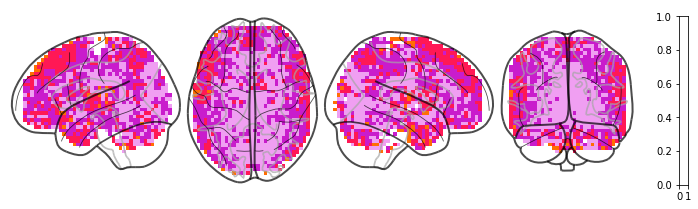

In [293]:
for model_name in model_names:
    for key in analysis:
        maps = []
        for model in data[model_name][key].keys():
            if model == 'models':
                models = data[model_name][key][model]
            else:
                name = '_'.join([model_name, model])
                path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
                name = 'Pearson_coeff_group_fdr_effect'
                maps.append(fetch_map(path, name)[0])
        # Small reordering of models so that layers are in increasing order
        maps 
        if key=='Hidden-layers':
            maps = maps[:2] + maps[5:] + maps[2:5]
            models = models[:2] + models[5:] + models[2:5]
            load = 0
        elif key=='Attention-layers':
            maps = maps[:1] + maps[4:] + maps[1:4]
            models = models[:1] + models[4:] + models[1:4]
            load = 1
        elif key=='Specific-attention-heads':
            maps = maps[:4] + maps[6:7] + maps[4:6] + maps[7:]
            models = models[:4] + models[6:7] + models[4:6] + models[7:]
            load = 0
        data_tmp = np.stack(masker.transform(map_) for map_ in maps)
        data_tmp = np.argmax(data_tmp, axis=0)
        #m = np.max(data_tmp)
        data_tmp = (data_tmp + load)
        print(np.unique(data_tmp))
        
        plot_name = "Pearson_coeff-{}-{}".format(model_name, key)
        
    
        colormap = plt.cm.gist_ncar  # define the colormap
        # extract all colors from the color map
        #cmaplist = [colormap(i) for i in np.linspace(0, colormap.N, len(models))]
        cmaplist = [colormap(i) for i in range(colormap.N)]
        indexes = [int(item) for item in np.linspace(0, colormap.N,  len(models)+1)]
        palette = np.array([cmaplist[index] for index in indexes[:-1]])


        # create the new map
        #cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        #    'Custom cmap', cmaplist, len(models)) 
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', palette, N=len(models)*2 ) #colormap(np.linspace(0, colormap.N, len(models)))
        # define the bins and normalize
        bounds = np.linspace(load, len(models)+load, len(models) + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, len(models)*2) # colormap.N

        print(vars(cmap))
        img = masker.inverse_transform(data_tmp)
        
        display = plotting.plot_glass_brain(
            img,
            colorbar=True,
            cmap=cmap,
            norm=norm,
            plot_abs=False,
            display_mode='lzry',
            title=plot_name)
        saving_path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/glass_brains/'.format(language))
        check_folder(saving_path)
        print(plot_name)
        #plt.show()
        display.savefig(saving_path + plot_name + '.png')
        nib.save(img, saving_path + plot_name + '.nii.gz')
        plt.close('all')
        
        print("\t\t-->Done")

In [ ]:
def layer_plot(X,Y, error, surnames, object_of_interest, roi, limit, save_folder, name):
    """Layer-wised plot per ROI
    """
    plot = plt.plot(X, Y)
    ax = plt.axes()
    plt.minorticks_on()
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='both')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='y')
    #plt.title('\n'.join(wrap(surnames[object_of_interest] + ' per ROI - {roi} - all voxels'.format(roi=roi))))
    plt.xlabel('Models', fontsize=16)
    plt.ylabel(surnames[object_of_interest], fontsize=16)
    ax.tick_params(axis='y', labelsize=12)
    plt.ylim(0,0.1)
    plt.xticks(rotation=30, fontsize=10, horizontalalignment='right')
    plt.errorbar(X, Y, error, linestyle='None', marker='^')
    plt.tight_layout()
    check_folder(save_folder)
    plt.savefig(os.path.join(save_folder, name))
    plt.close()

### Impact of fine-tuning

In [ ]:
scp -r ap259944@is153803.intra.cea.fr:/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/Attention-layers-Average/ /Users/alexpsq/Code/Parietal/analysis
scp -r ap259944@is153803.intra.cea.fr:/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/Attention-layers-3rd_Quartile/ /Users/alexpsq/Code/Parietal/analysis
scp -r ap259944@is153803.intra.cea.fr:/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/Hidden-layers-3rd_Quartile/ /Users/alexpsq/Code/Parietal/analysis
scp -r ap259944@is153803.intra.cea.fr:/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/Hidden-layers-Average/ /Users/alexpsq/Code/Parietal/analysis
scp -r ap259944@is153803.intra.cea.fr:/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/glass_brains/ /Users/alexpsq/Code/Parietal/analysis
scp -r ap259944@is153803.intra.cea.fr:/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/Specific-attention-heads-Average/ /Users/alexpsq/Code/Parietal/analysis
scp -r ap259944@is153803.intra.cea.fr:/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/Specific-attention-heads-3rd_Quartile/ /Users/alexpsq/Code/Parietal/analysis


Relation	| Head	| Accuracy	| Baseline

All      	| 7-6 	| 34.5    	| 26.3 	 (1)
prep    	| 7-4 	| 66.7    	| 61.8 	 (-1)
pobj    	| 9-6 	| 76.3    	| 34.6 	 (-2)
det     	| 8-11	| 94.3    	| 51.7 	 (1)
nn      	| 4-10	| 70.4    	| 70.2 	 (1)
nsubj    	| 8-2 	| 58.5    	| 45.5 	 (1)
amod    	| 4-10	| 75.6    	| 68.3 	 (1)
dobj    	| 8-10	| 86.8    	| 40.0 	 (-2)
advmod    	| 7-6 	| 48.8    	| 40.2 	 (1)
aux     	| 4-10	| 81.1    	| 71.5 	 (1)
poss    	| 7-6 	| 80.5    	| 47.7 	 (1)
auxpass    	| 4-10	| 82.5    	| 40.5 	 (1)
ccomp    	| 8-1 	| 48.8    	| 12.4 	 (-2)
mark    	| 8-2 	| 50.7    	| 14.5 	 (2)
prt     	| 6-7 	| 99.1    	| 91.4 	 (-1)

### Full models

In [ ]:
data_full = {}
model_full_names = ['bert-base-cased_{}_all-hidden-layer',
               'bert-base-cased_{}_all-hidden-layers_pca_300',
               'bert-base-cased_{}_all-attention-layers',
               'bert-base-cased_{}_all-attention-layers_pca_300',
               'bert-base-cased_sequential_{}_all-hidden-layer',
               'bert-base-cased_sequential_{}_all-hidden-layers_pca_300',
               'bert-base-cased_sequential_{}_all-attention-layers',
               'bert-base-cased_sequential_{}_all-attention-layers_pca_300',
               'gpt2_{}_all-hidden-layer',
               'gpt2_{}_all-hidden-layers_pca_300',
               'gpt2_{}_all-attention-layers',
               'gpt2_{}_all-attention-layers_pca_300',
               'glove_300_{}',
               'BF_rms_{}',
               'BF_log_frequency_{}',
               'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_{}_all-out-layers',
               'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_{}_all-in-layers',
               'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
               'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_{}_all-forget-layers',
               'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_{}_all-c_tilde-layers',
               'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_{}_all-cell-layers',
               'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-out-layers',
               'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-in-layers',
               'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
               'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-forget-layers',
               'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-c_tilde-layers',
               'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-cell-layers'
              ]

for model_name in model_full_names:
    data_full[model_name.replace('_{}', '')] = {}
    R2_maps = {}
    Pearson_coeff_maps = {}
    for subject_id in tqdm(possible_subjects_id(language)):
        subject = get_subject_name(subject_id)
        path_to_map = os.path.join(OUTPUT_PATH, subject, model_name.format(subject_id))
        R2_maps[subject] = fetch_map(path_to_map, 'R2')
        Pearson_coeff_maps[subject] = fetch_map(path_to_map, 'Pearson_coeff')
        print(subject, '-', len(R2_maps[subject]), '-', len(Pearson_coeff_maps[subject]))
    R2_lists = list(zip(*R2_maps.values()))
    Pearson_coeff_lists = list(zip(*Pearson_coeff_maps.values()))
    try:
        data_full[model_name.replace('_{}', '')] = {'R2': list(R2_lists[0]),
                            'Pearson_coeff': list(Pearson_coeff_lists[0])
                            }
    except:
        print(model_name)


In [ ]:
smoothing_fwhm = None # 5.0
for model_name in model_full_names:
    # R2
    name = model_name.replace('_{}', '')
    imgs = data_full[name]['R2']
    output_dir = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    check_folder(output_dir)
    create_one_sample_t_test(name + '_R2', imgs, output_dir, smoothing_fwhm=smoothing_fwhm, vmax=None)
    # Pearson coefficient
    imgs = data_full[name]['Pearson_coeff']
    create_one_sample_t_test(name + '_Pearson_coeff', imgs, output_dir, smoothing_fwhm=smoothing_fwhm, vmax=None)
    plt.close('all')

We study:
- BERT vs GPT2
- BERT (pca) vs GPT2 (pca)
- BERT (pca) vs LSTM (H)
- GPT2 (pca) vs LSTM (H)
- LSTM (H) vs GLOVE
- BERT (pca) vs GLOVE
- GPT2 (pca) vs GLOVE

But also:
- BERT (H) vs BERT (A)
- GPT2 (H) vs GPT2 (A)
- LSTM (O/I/H/F/C/T) vs LSTM (O/I/H/F/C/T)



In [ ]:
comparisons = {'BERT(H)_vs_GPT2(H)' : ['bert-base-cased_all-hidden-layer', 'gpt2_all-hidden-layer'],
              'BERT(A)_vs_GPT2(A)' : ['bert-base-cased_all-attention-layers', 'gpt2_all-attention-layers'],
              'BERT(H)_vs_BERT(A)' : ['bert-base-cased_all-hidden-layer', 'bert-base-cased_all-attention-layers'],
              'GPT2(H)_vs_GPT2(A)' : ['gpt2_all-hidden-layer', 'gpt2_all-attention-layers'],
              'BERT(Hpca)_vs_GPT2(Hpca)' : ['bert-base-cased_all-hidden-layers_pca_300', 'gpt2_all-hidden-layers_pca_300'],
              'BERT(Apca)_vs_GPT2(Apca)' : ['bert-base-cased_all-attention-layers_pca_300', 'gpt2_all-attention-layers_pca_300'],
              'BERT(Hpca)_vs_BERT(Apca)' : ['bert-base-cased_all-hidden-layers_pca_300', 'bert-base-cased_all-attention-layers_pca_300'],
              'GPT2(Hpca)_vs_GPT2(Apca)' : ['gpt2_all-hidden-layers_pca_300', 'gpt2_all-attention-layers_pca_300'],
              
              'BERT(Hpca)_vs_LSTM_650(Hpca)' : ['bert-base-cased_all-hidden-layers_pca_300', 'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-hidden-layers'],
              'GPT2(Hpca)_vs_LSTM_650(Hpca)' : ['gpt2_all-hidden-layers_pca_300', 'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-hidden-layers'],
              'BERT(Hpca)_vs_LSTM_300(H)' : ['bert-base-cased_all-hidden-layers_pca_300', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers'],
              'GPT2(Hpca)_vs_LSTM_300(H)' : ['gpt2_all-hidden-layers_pca_300', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers'],
              
              'LSTM_650(Hpca)_vs_Glove' : ['LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-hidden-layers', 'glove_300'],
              'LSTM_300(H)_vs_Glove' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'glove_300'],
              'BERT(Hpca)_vs_Glove' : ['bert-base-cased_all-hidden-layers_pca_300', 'glove_300'],
              'GPT2(Hpca)_vs_Glove' : ['gpt2_all-hidden-layers_pca_300', 'glove_300'],
              
              'LSTM_650(Hpca)_vs_LSTM_650(Opca)' : ['LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-out-layers'],
              'LSTM_300(H)_vs_LSTM_300(O)' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-out-layers'],
              'LSTM_650(Hpca)_vs_LSTM_650(Ipca)' : ['LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-in-layers'],
              'LSTM_300(H)_vs_LSTM_300(I)' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-in-layers'],
              'LSTM_650(Hpca)_vs_LSTM_650(Fpca)' : ['LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-forget-layers'],
              'LSTM_300(H)_vs_LSTM_300(F)' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-forget-layers'],
              'LSTM_650(Hpca)_vs_LSTM_650(Cpca)' : ['LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-cell-layers'],
              'LSTM_300(H)_vs_LSTM_300(C)' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-cell-layers'],
              'LSTM_650(Hpca)_vs_LSTM_650(Tpca)' : ['LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_650_nhid_650_nlayers_2_dropout_02_wiki_kristina_english_all-c_tilde-layers'],
              'LSTM_300(H)_vs_LSTM_300(T)' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-c_tilde-layers']
}



In [ ]:
for comparison in comparisons.keys():
    # R2
    print('Retrieving data...')
    imgs_1 = data_full[comparisons[comparison][0]]['R2']
    imgs_2 = data_full[comparisons[comparison][1]]['R2']

    imgs = []
    for img_1, img_2 in zip(imgs_1, imgs_2):
        i1 = nib.load(img_1)
        i2 = nib.load(img_2)
        imgs.append(new_img_like(i1, i1.get_data() - i2.get_data()))

    output_dir = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    check_folder(output_dir)
    print('One sample t-test...')
    create_one_sample_t_test(name + '_R2', imgs, output_dir, smoothing_fwhm=smoothing_fwhm, vmax=None)
    # Pearson Coefficient
    print('Retrieving data...')
    imgs_1 = data_full[comparisons[comparison][0]]['Pearson_coeff']
    imgs_2 = data_full[comparisons[comparison][1]]['Pearson_coeff']

    imgs = []
    for img_1, img_2 in zip(imgs_1, imgs_2):
        i1 = nib.load(img_1)
        i2 = nib.load(img_2)
        imgs.append(new_img_like(i1, i1.get_data() - i2.get_data()))
    create_one_sample_t_test(name + '_Pearson_coeff', imgs, output_dir, smoothing_fwhm=smoothing_fwhm, vmax=None)
